# UrbanSound8K DeepLearning Classification

# Introduction

In this project, we focus on developing deep learning–based classifiers for the **UrbanSound8K** dataset, a widely used benchmark that contains 8732 labeled audio excerpts spanning ten everyday urban sound classes, including *car horn*, *dog bark*, *siren*, *engine idling*, *jackhammer*, among others. Each sound clip is no longer than four seconds, presenting challenges related to signal variability, noise, and differences in duration or sampling rate.

The main objective of this work is to design, implement, and evaluate two deep learning architectures, selected from **multilayer perceptrons (MLPs)**, **convolutional neural networks (CNNs)** and **recurrent neural networks (RNNs)**, to classify previously unseen sound excerpts into their respective categories. This involves a complete machine learning pipeline: preprocessing raw audio data, extracting suitable features, defining and training neural network models and assessing their performance through a rigorous **10-fold cross-validation** scheme.

In [1]:
!pip install --break-system-packages -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import os
import struct
import matplotlib.pyplot as plt
import IPython.display as ipd
import pandas as pd
import numpy as np
import librosa
import soundfile as sf

from scipy.io import wavfile as wav
from scipy.signal import chirp

# Data Exploration

Before designing any preprocessing pipeline or building models, it is essential to first understand the characteristics of the UrbanSound8K dataset.

The purpose of the data exploration phase is to inspect how the data is structured, examine the metadata, and observe the properties of the audio signals themselves. 

By looking at aspects such as waveform shapes, sampling rates, class distribution, and basic time–frequency representations, we can identify important patterns and potential challenges—such as variable durations, different recording conditions, or inconsistent sampling rates. This initial exploration provides the foundation for the decisions made later in the data preparation phase, ensuring that the preprocessing steps are well-motivated and adapted to the nature of the dataset.

In [3]:
data = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
print(data.shape)

(8732, 8)


In [4]:
data.head()

slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  
0          dog_bark  
1  children_playing  
2  children_playing  
3  children_playing  
4  children_playing

In [5]:
appended = []
for i in range(1,11):
    appended.append(data[data.fold == i]['class'].value_counts())
    
class_distribution = pd.DataFrame(appended)
class_distribution = class_distribution.reset_index()
class_distribution['index'] = ["fold"+str(x) for x in range(1,11)]
class_distribution

class   index  jackhammer  dog_bark  drilling  children_playing  \
0       fold1         120       100       100               100   
1       fold2         120       100       100               100   
2       fold3         120       100       100               100   
3       fold4         120       100       100               100   
4       fold5         120       100       100               100   
5       fold6          68       100       100               100   
6       fold7          76       100       100               100   
7       fold8          78       100       100               100   
8       fold9          82       100       100               100   
9      fold10          96       100       100               100   

class  air_conditioner  street_music  engine_idling  siren  car_horn  gun_shot  
0                  100           100             96     86        36        35  
1                  100           100            100     91        42        35  
2                  100           100            107    119        43        36  
3                  100           100            107    166        59        38  
4                  100           100            107     71        98        40  
5                  100           100            107     74        28        46  
6                  100           100            106     77        28        51  
7                  100           100             88     80        30        30  
8                  100           100             89     82        32        31  
9                  100           100             93     83        33        32

In [6]:
print(data['class'].value_counts(normalize=True))

class
dog_bark            0.114521
children_playing    0.114521
air_conditioner     0.114521
street_music        0.114521
jackhammer          0.114521
engine_idling       0.114521
drilling            0.114521
siren               0.106390
car_horn            0.049130
gun_shot            0.042831
Name: proportion, dtype: float64


After examining the metadata and overall structure of the dataset, we gained a clearer understanding of how the samples are organized across the 10 folds, how the classes are distributed, and what information accompanies each audio file. This step allowed us to confirm the integrity of the cross-validation setup, identify some class imbalance, and recognize the variety of recording conditions present in the dataset. We will further analyse the dataset with better graphs later, however, with this structural overview in place, we were prepared to look more closely at the audio signals themselves, starting with basic waveform inspection and other signal-level characteristics.

### Plotting wave



In [7]:
def path_class(filename):
    excerpt = data[data['slice_file_name'] == filename]
    path_name = os.path.join('UrbanSound8K/audio', 'fold'+str(excerpt.fold.values[0]), filename)
    return path_name, excerpt['class'].values[0]

In [8]:
def wav_plotter(full_path, class_label):   
    rate, wav_sample = wav.read(full_path)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    print('sampling rate: ',rate,'Hz')
    print('bit depth: ',bit_depth)
    print('number of channels: ',wav_sample.shape[1])
    print('duration: ',wav_sample.shape[0]/rate,' second')
    print('number of samples: ',len(wav_sample))
    print('class: ',class_label)
    plt.figure(figsize=(12, 4))
    plt.plot(wav_sample) 
    return ipd.Audio(full_path)

sampling rate:  44100 Hz
bit depth:  16
number of channels:  2
duration:  4.0  second
number of samples:  176400
class:  children_playing


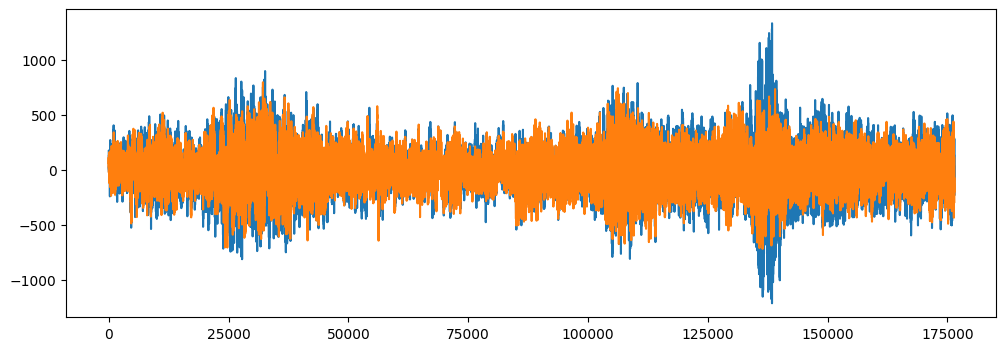

In [9]:
fullpath, label = path_class('100263-2-0-117.wav')
wav_plotter(fullpath,label)

In [10]:
def wav_fmt_parser(file_name):
    full_path, _ = path_class(file_name)
    wave_file = open(full_path,"rb")
    riff_fmt = wave_file.read(36)
    n_channels_string = riff_fmt[22:24]
    n_channels = struct.unpack("H",n_channels_string)[0]
    s_rate_string = riff_fmt[24:28]
    s_rate = struct.unpack("I",s_rate_string)[0]
    bit_depth_string = riff_fmt[-2:]
    bit_depth = struct.unpack("H",bit_depth_string)[0]
    return (n_channels,s_rate,bit_depth)

In [11]:
wav_fmt_data = [wav_fmt_parser(i) for i in data.slice_file_name]
data[['n_channels','sampling_rate','bit_depth']] = pd.DataFrame(wav_fmt_data)
print(data.head())

      slice_file_name    fsID  start        end  salience  fold  classID  \
0    100032-3-0-0.wav  100032    0.0   0.317551         1     5        3   
1  100263-2-0-117.wav  100263   58.5  62.500000         1     5        2   
2  100263-2-0-121.wav  100263   60.5  64.500000         1     5        2   
3  100263-2-0-126.wav  100263   63.0  67.000000         1     5        2   
4  100263-2-0-137.wav  100263   68.5  72.500000         1     5        2   

              class  n_channels  sampling_rate  bit_depth  
0          dog_bark           2          44100         16  
1  children_playing           2          44100         16  
2  children_playing           2          44100         16  
3  children_playing           2          44100         16  
4  children_playing           2          44100         16  


In [12]:
print(data.n_channels.value_counts(), end = "\n\n\n")
print(data.bit_depth.value_counts(), end = "\n\n\n")
print(data.sampling_rate.value_counts())

n_channels
2    7993
1     739
Name: count, dtype: int64


bit_depth
16    5758
24    2753
32     169
8       43
4        9
Name: count, dtype: int64


sampling_rate
44100     5370
48000     2502
96000      610
24000       82
16000       45
22050       44
11025       39
192000      17
8000        12
11024        7
32000        4
Name: count, dtype: int64


After exploring a few representative audio samples and examining their internal WAV format structure using the wav_fmt_parser function, we began to notice that the dataset contains recordings with different technical properties. In particular, the parser allowed us to confirm details such as the number of channels, bit depth, and, most importantly, the sampling rate of each file. This was a key observation, because inconsistent sampling rates imply that the raw audio signals are not directly comparable in their current form. Before applying any preprocessing or feature extraction method, we need to ensure that all samples share a common temporal resolution. This naturally led us to revisit the principles that govern sampling and signal reconstruction, which is why the next step was to consider the Nyquist Sampling Theorem and its implications for our resampling strategy.

## Nyquist Sampling Theorem 


The **Nyquist Sampling Theorem** provides the fundamental rule for converting a continuous signal into a discrete one without losing information. It states that to accurately capture and later reconstruct a signal, the **sampling rate** must be at least **twice the highest frequency** present in that signal. 

Sampling faster than this minimum ensures that the frequency content is preserved, while sampling below it leads to **aliasing**, where different frequencies become indistinguishable.

If a signal contains no frequency components above $f_\text{max}$, then perfect reconstruction is possible as long as the sampling rate satisfies:

$$
f_s \ge 2 f_\text{max}
$$

The value $2 f_\text{max}$ is known as the **Nyquist rate**.

In **audio processing**, this theorem guides how we choose or convert sampling rates to ensure that important sound information is preserved.

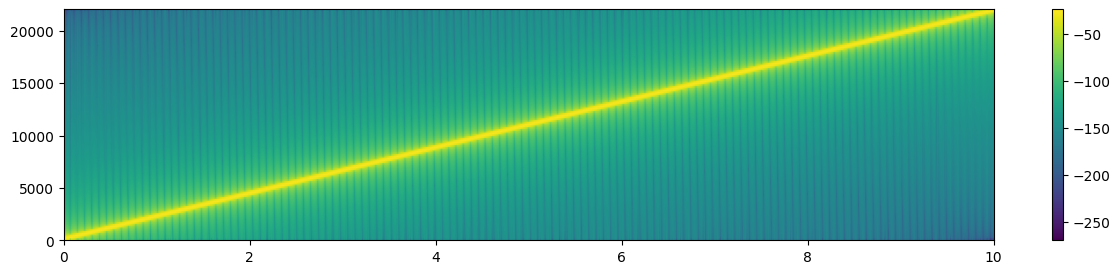

In [13]:
fs = 44100
T = 10
t = np.linspace(0, T, T*fs, endpoint=False)

w = chirp(t, f0=20, f1=22050, t1=T, method='linear')
sf.write('sine_sweep_44100.wav', w, fs)

plt.figure(figsize=(15,3))
plt.specgram(w, Fs=44100)
plt.colorbar()
_=plt.axis((0,10,0,22050))
ipd.Audio('sine_sweep_44100.wav')

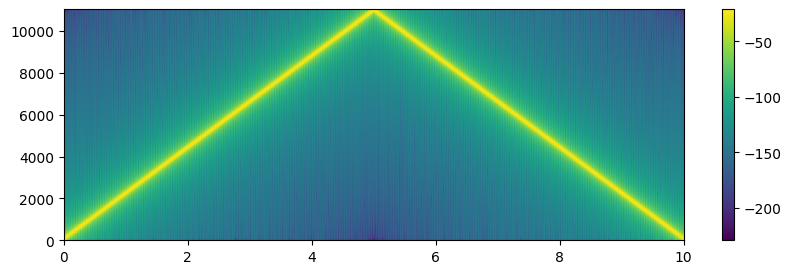

In [14]:
down_sampled = w[::2]
sf.write('sine_sweep_downsampled.wav', down_sampled, 22050)

plt.figure(figsize=(10,3))
plt.specgram(down_sampled, Fs=22050)
plt.colorbar()
_=plt.axis((0,10,0,11050))
ipd.Audio('sine_sweep_downsampled.wav')

In conclusion, while the Nyquist-Shannon sampling theorem establishes the theoretical lower bound for sampling rates (2B), the practical implementation of resampling requires careful handling of anti-aliasing to prevent signal distortion.

We now turn our attention to a robust statistical analysis of the UrbanSound8K dataset to understand its class distributions and structural characteristics.

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import warnings
warnings.filterwarnings('ignore')

In [16]:
METADATA_PATH = 'UrbanSound8K/metadata/UrbanSound8K.csv'
AUDIO_BASE_PATH = 'UrbanSound8K/audio'

In [17]:
def dataset_overview(df):
    """Print comprehensive dataset statistics"""
    print("=" * 60)
    print("URBANSOUND8K DATASET OVERVIEW")
    print("=" * 60)
    print(f"Total samples: {len(df)}")
    print(f"Number of classes: {df['classID'].nunique()}")
    print(f"Number of folds: {df['fold'].nunique()}")
    print(f"\nClass distribution:")
    print(df['class'].value_counts().sort_index())
    print(f"\nSamples per fold:")
    print(df['fold'].value_counts().sort_index())
    print("=" * 60)

def basic_statistics(df):
    """Calculate and display basic statistical measures"""
    stats_dict = {
        'Mean': df.groupby('class')['classID'].count().mean(),
        'Median': df.groupby('class')['classID'].count().median(),
        'Std Dev': df.groupby('class')['classID'].count().std(),
        'Min': df.groupby('class')['classID'].count().min(),
        'Max': df.groupby('class')['classID'].count().max()
    }
    
    print("\nDataset Statistics:")
    for key, value in stats_dict.items():
        print(f"{key}: {value:.2f}")
    
    return stats_dict

In [18]:
def plot_class_distribution(df):
    """Plot class distribution with counts"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Bar plot
    class_counts = df['class'].value_counts().sort_index()
    ax1.bar(range(len(class_counts)), class_counts.values, color='steelblue')
    ax1.set_xlabel('Class', fontsize=12)
    ax1.set_ylabel('Number of Samples', fontsize=12)
    ax1.set_title('Class Distribution - Bar Chart', fontsize=14, fontweight='bold')
    ax1.set_xticks(range(len(class_counts)))
    ax1.set_xticklabels(class_counts.index, rotation=45, ha='right')
    ax1.grid(axis='y', alpha=0.3)
    
    # Pie chart
    ax2.pie(class_counts.values, labels=class_counts.index, autopct='%1.1f%%',
            startangle=90, colors=sns.color_palette('Set3', len(class_counts)))
    ax2.set_title('Class Distribution - Percentage', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

def plot_fold_distribution(df):
    """Plot distribution across folds"""
    fig, ax = plt.subplots(figsize=(12, 6))
    
    fold_counts = df['fold'].value_counts().sort_index()
    bars = ax.bar(fold_counts.index, fold_counts.values, color='coral')
    
    ax.set_xlabel('Fold', fontsize=12)
    ax.set_ylabel('Number of Samples', fontsize=12)
    ax.set_title('Sample Distribution Across Folds', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10)
    
    plt.tight_layout()
    plt.show()

def plot_class_fold_heatmap(df):
    """Create heatmap showing class distribution across folds"""
    pivot_table = df.pivot_table(
        values='slice_file_name',
        index='class',
        columns='fold',
        aggfunc='count',
        fill_value=0
    )
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(pivot_table, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': 'Number of Samples'})
    plt.title('Class Distribution Across Folds', fontsize=14, fontweight='bold')
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Class', fontsize=12)
    plt.tight_layout()
    plt.show()

In [19]:
def load_audio(file_path, sr=22050):
    """Load audio file and return signal and sample rate"""
    y, sr = librosa.load(file_path, sr=sr)
    return y, sr

def plot_waveform(y, sr, title="Audio Waveform"):
    """Plot audio waveform"""
    plt.figure(figsize=(14, 4))
    librosa.display.waveshow(y, sr=sr, alpha=0.6)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Amplitude', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(y, sr, title="Spectrogram"):
    """Plot spectrogram"""
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='hz', cmap='viridis')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mel_spectrogram(y, sr, title="Mel Spectrogram"):
    """Plot mel-scaled spectrogram"""
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', cmap='coolwarm')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Mel Frequency', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_mfcc(y, sr, n_mfcc=13, title="MFCC Features"):
    """Plot Mel-frequency cepstral coefficients"""
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    
    plt.figure(figsize=(14, 6))
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='RdBu_r')
    plt.colorbar(label='MFCC Coefficient Value')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('MFCC Coefficients', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_chromagram(y, sr, title="Chromagram"):
    """Plot chromagram"""
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='plasma')
    plt.colorbar(label='Magnitude')
    plt.title(title, fontsize=14, fontweight='bold')
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Pitch Class', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_spectral_centroid(y, sr, title="Spectral Centroid"):
    """Plot spectral centroid over time"""
    cent = librosa.feature.spectral_centroid(y=y, sr=sr)
    times = librosa.times_like(cent, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, cent.T, color='steelblue', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_zero_crossing_rate(y, title="Zero Crossing Rate"):
    """Plot zero crossing rate over time"""
    zcr = librosa.feature.zero_crossing_rate(y)
    frames = range(len(zcr[0]))
    
    plt.figure(figsize=(14, 4))
    plt.plot(frames, zcr[0], color='green', linewidth=1.5)
    plt.xlabel('Frame', fontsize=12)
    plt.ylabel('Zero Crossing Rate', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_spectral_rolloff(y, sr, title="Spectral Rolloff"):
    """Plot spectral rolloff over time"""
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    times = librosa.times_like(rolloff, sr=sr)
    
    plt.figure(figsize=(14, 4))
    plt.plot(times, rolloff.T, color='purple', linewidth=1.5)
    plt.xlabel('Time (s)', fontsize=12)
    plt.ylabel('Frequency (Hz)', fontsize=12)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [20]:
def analyze_audio_comprehensive(file_path, class_name="Unknown", sr=22050):
    """Perform comprehensive analysis on a single audio file"""
    y, sr = load_audio(file_path, sr)
    
    print(f"\n{'='*60}")
    print(f"Audio Analysis: {class_name}")
    print(f"{'='*60}")
    print(f"Duration: {len(y)/sr:.2f} seconds")
    print(f"Sample rate: {sr} Hz")
    print(f"Number of samples: {len(y)}")
    print(f"Max amplitude: {np.max(np.abs(y)):.4f}")
    print(f"Mean amplitude: {np.mean(np.abs(y)):.4f}")
    
    # Plot all visualizations
    plot_waveform(y, sr, f"Waveform - {class_name}")
    plot_spectrogram(y, sr, f"Spectrogram - {class_name}")
    plot_mel_spectrogram(y, sr, f"Mel Spectrogram - {class_name}")
    plot_mfcc(y, sr, title=f"MFCC - {class_name}")
    plot_chromagram(y, sr, f"Chromagram - {class_name}")
    plot_spectral_centroid(y, sr, f"Spectral Centroid - {class_name}")
    plot_zero_crossing_rate(y, f"Zero Crossing Rate - {class_name}")
    plot_spectral_rolloff(y, sr, f"Spectral Rolloff - {class_name}")

def extract_features(y, sr):
    """Extract multiple audio features"""
    features = {}
    
    # Temporal features
    features['duration'] = len(y) / sr
    features['mean_amplitude'] = np.mean(np.abs(y))
    features['max_amplitude'] = np.max(np.abs(y))
    features['rms_energy'] = np.sqrt(np.mean(y**2))
    
    # Spectral features
    features['zcr_mean'] = np.mean(librosa.feature.zero_crossing_rate(y))
    features['zcr_std'] = np.std(librosa.feature.zero_crossing_rate(y))
    
    spectral_centroids = librosa.feature.spectral_centroid(y=y, sr=sr)
    features['spectral_centroid_mean'] = np.mean(spectral_centroids)
    features['spectral_centroid_std'] = np.std(spectral_centroids)
    
    spectral_rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    features['spectral_rolloff_mean'] = np.mean(spectral_rolloff)
    features['spectral_rolloff_std'] = np.std(spectral_rolloff)
    
    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    features['spectral_bandwidth_mean'] = np.mean(spectral_bandwidth)
    features['spectral_bandwidth_std'] = np.std(spectral_bandwidth)
    
    # MFCC features
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    for i in range(13):
        features[f'mfcc_{i}_mean'] = np.mean(mfccs[i])
        features[f'mfcc_{i}_std'] = np.std(mfccs[i])
    
    # Chroma features
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    features['chroma_mean'] = np.mean(chroma)
    features['chroma_std'] = np.std(chroma)
    
    return features

def compare_classes_features(file_paths, class_names, sr=22050):
    """Compare features across multiple audio classes"""
    all_features = []
    
    for file_path, class_name in zip(file_paths, class_names):
        y, sr = load_audio(file_path, sr)
        features = extract_features(y, sr)
        features['class'] = class_name
        all_features.append(features)
    
    features_df = pd.DataFrame(all_features)
    
    # Plot comparison
    numeric_cols = features_df.select_dtypes(include=[np.number]).columns[:8]
    
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.flatten()
    
    for idx, col in enumerate(numeric_cols):
        axes[idx].bar(features_df['class'], features_df[col], color=sns.color_palette('husl', len(class_names)))
        axes[idx].set_title(col.replace('_', ' ').title(), fontsize=10, fontweight='bold')
        axes[idx].tick_params(axis='x', rotation=45)
        axes[idx].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return features_df

In [21]:
def analyze_class_samples(df, audio_base_path, class_name, num_samples=3, sr=22050):
    """Analyze multiple samples from a specific class"""
    class_df = df[df['class'] == class_name].head(num_samples)
    
    for idx, row in class_df.iterrows():
        file_path = f"{audio_base_path}/fold{row['fold']}/{row['slice_file_name']}"
        y, sr = load_audio(file_path, sr)
        
        print(f"\n--- Sample {idx+1} ---")
        print(f"File: {row['slice_file_name']}")
        
        plot_waveform(y, sr, f"{class_name} - Sample {idx+1}")
        plot_mel_spectrogram(y, sr, f"{class_name} Mel Spectrogram - Sample {idx+1}")

In [22]:
def plot_channel_distribution_from_files(df, audio_base_path):
    """
    Analyzes all audio files in the dataset to determine if they are Mono (1) 
    or Stereo (2) and plots the distribution.
    """
    channel_counts = []
    print("Starting audio channel analysis. This will take a moment as it checks 8732 files...")
    
    for index, row in df.iterrows():
        file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        try:
            y, sr = librosa.load(file_path, sr=None, mono=False, duration=0.01)
            
            # Check the shape: 1D array is Mono, 2D array (channels x samples) is Stereo/Multi
            if y.ndim == 1:
                channel_counts.append("Mono (1)")
            elif y.ndim == 2 and y.shape[0] == 2:
                channel_counts.append("Stereo (2)")
            else:
                channel_counts.append(f"Multi ({y.shape[0]})")
                
        except Exception as e:
            channel_counts.append("Error/Missing")

    channel_series = pd.Series(channel_counts)
    counts = channel_series.value_counts()
    
    counts_ordered = counts.reindex(['Mono (1)', 'Stereo (2)', 'Multi (3+)', 'Error/Missing'], fill_value=0)
    counts_ordered = counts_ordered[counts_ordered > 0]
    
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=counts_ordered.index, y=counts_ordered.values, palette="viridis")
    
    plt.title('Distribution of Audio Channels in UrbanSound8K', fontsize=15)
    plt.ylabel('Count', fontsize=12)
    plt.xlabel('Channel Type', fontsize=12)
    
    plt.bar_label(ax.containers[0], padding=3)
    plt.grid(axis='y', alpha=0.3)
    plt.show()
    
    print("\n--- Channel Analysis Summary ---")
    print(counts_ordered)

In [23]:
# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

df = pd.read_csv(METADATA_PATH)

In [24]:
dataset_overview(df)
basic_statistics(df)

URBANSOUND8K DATASET OVERVIEW
Total samples: 8732
Number of classes: 10
Number of folds: 10

Class distribution:
class
air_conditioner     1000
car_horn             429
children_playing    1000
dog_bark            1000
drilling            1000
engine_idling       1000
gun_shot             374
jackhammer          1000
siren                929
street_music        1000
Name: count, dtype: int64

Samples per fold:
fold
1     873
2     888
3     925
4     990
5     936
6     823
7     838
8     806
9     816
10    837
Name: count, dtype: int64

Dataset Statistics:
Mean: 873.20
Median: 1000.00
Std Dev: 249.93
Min: 374.00
Max: 1000.00


{'Mean': np.float64(873.2),
 'Median': np.float64(1000.0),
 'Std Dev': np.float64(249.92790071449718),
 'Min': np.int64(374),
 'Max': np.int64(1000)}

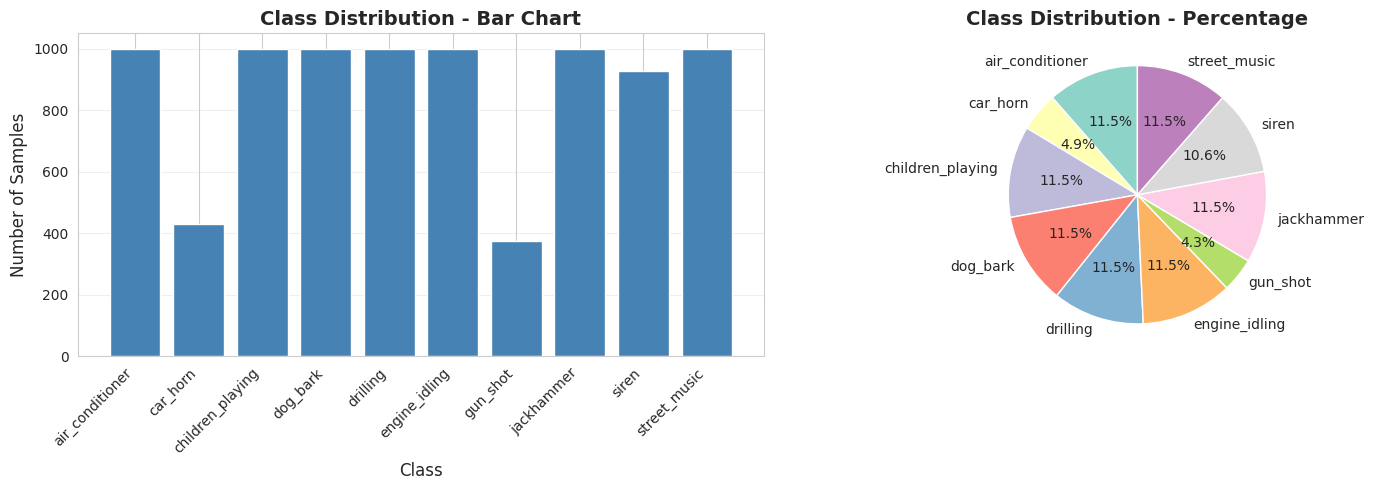

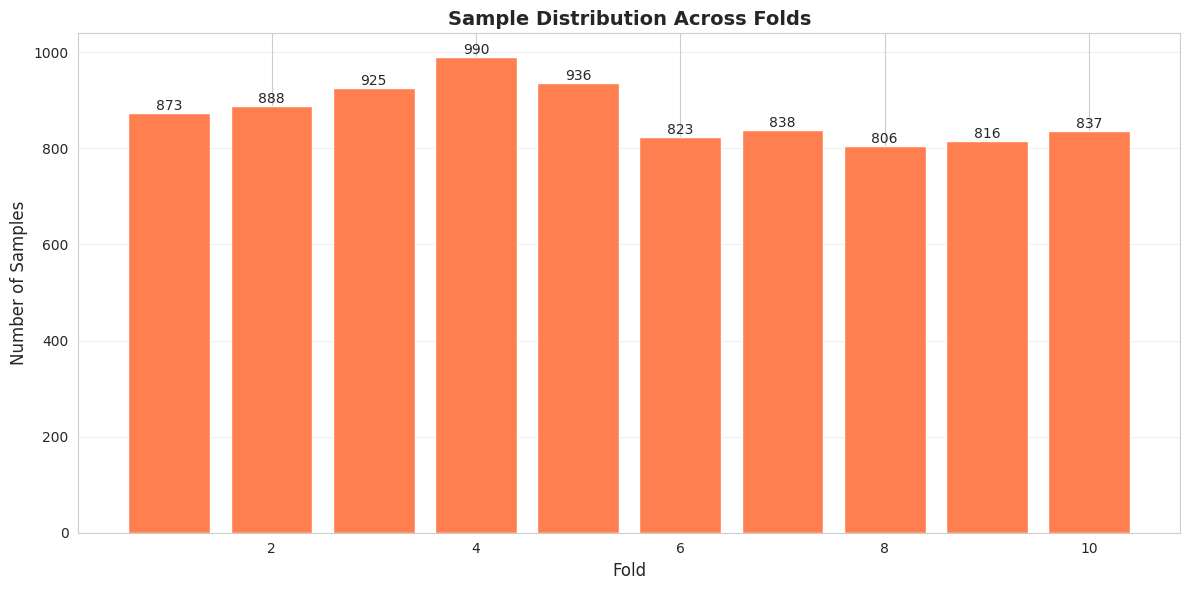

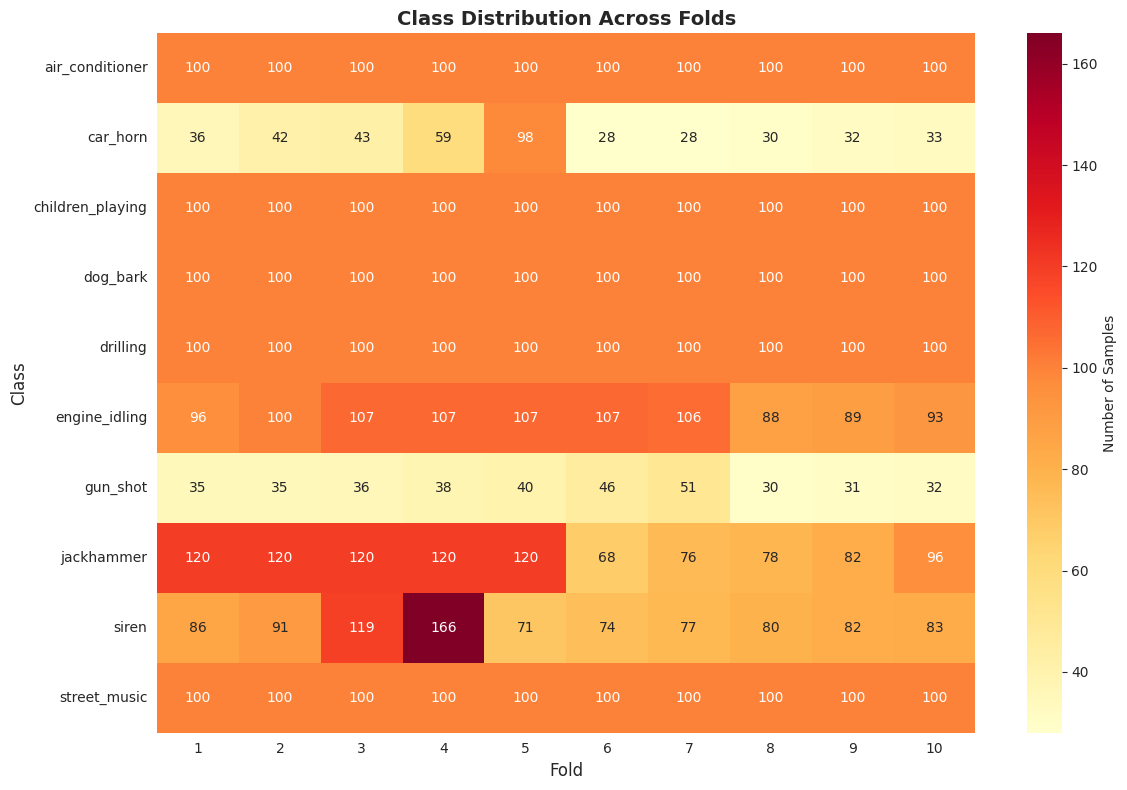

In [25]:
plot_class_distribution(df)
plot_fold_distribution(df)
plot_class_fold_heatmap(df)

Starting audio channel analysis. This will take a moment as it checks 8732 files...


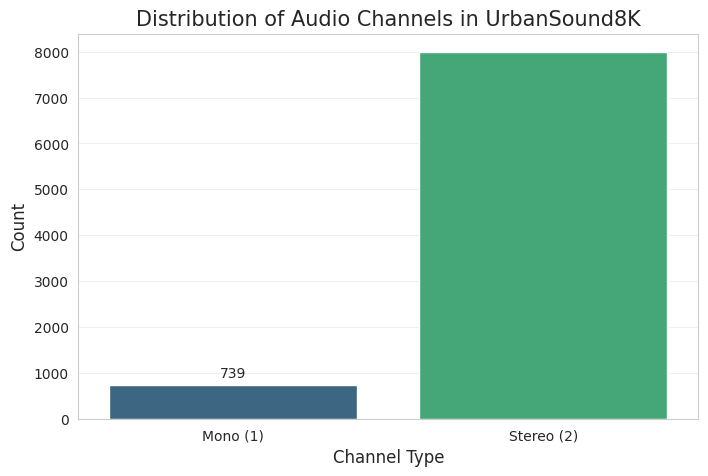


--- Channel Analysis Summary ---
Mono (1)       739
Stereo (2)    7993
Name: count, dtype: int64


In [26]:
plot_channel_distribution_from_files(df, AUDIO_BASE_PATH)

In [27]:
def get_audio_path(df, audio_base_path, index=0):
    """
        Helper function to get a valid audio file path from the dataframe
        """
    row = df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']

def get_class_audio_path(df, audio_base_path, class_name, index=0):
    """
        Get audio file path for a specific class
        """
    class_df = df[df['class'] == class_name]
    
    if len(class_df) == 0:
        raise ValueError(f"No samples found for class: {class_name}")
    
    if index >= len(class_df):
        raise ValueError(f"Index {index} out of range. Class has {len(class_df)} samples")
    
    row = class_df.iloc[index]
    file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
    
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Audio file not found: {file_path}")
    
    return file_path, row['class']


Audio Analysis: dog_bark
Duration: 0.32 seconds
Sample rate: 22050 Hz
Number of samples: 7002
Max amplitude: 0.9859
Mean amplitude: 0.0901


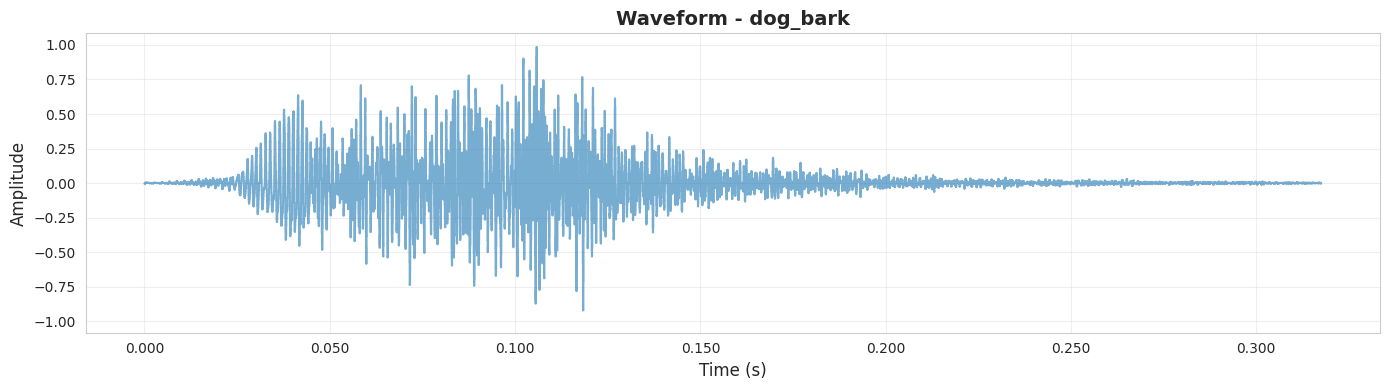

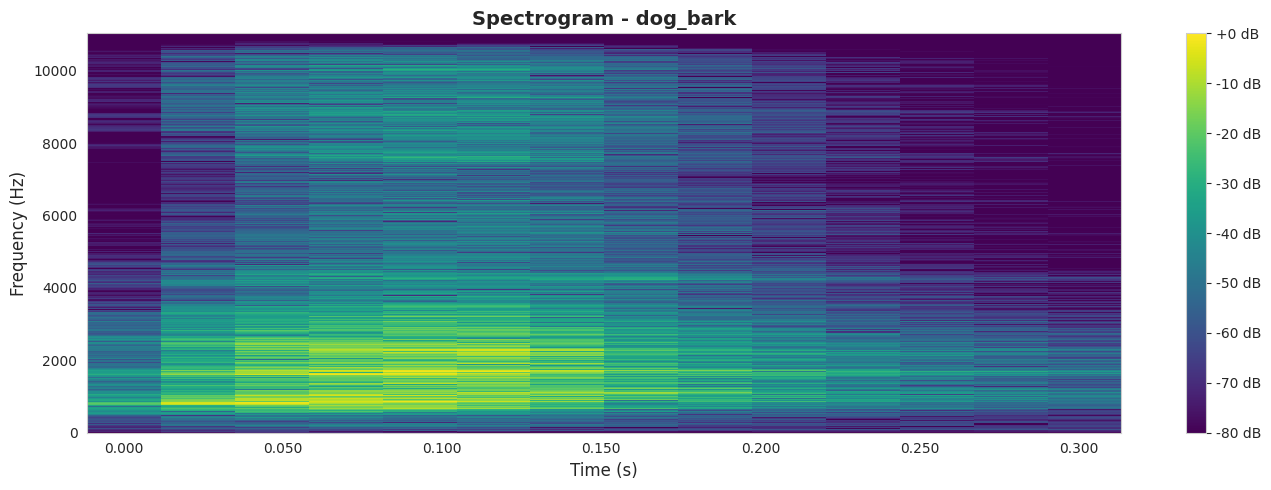

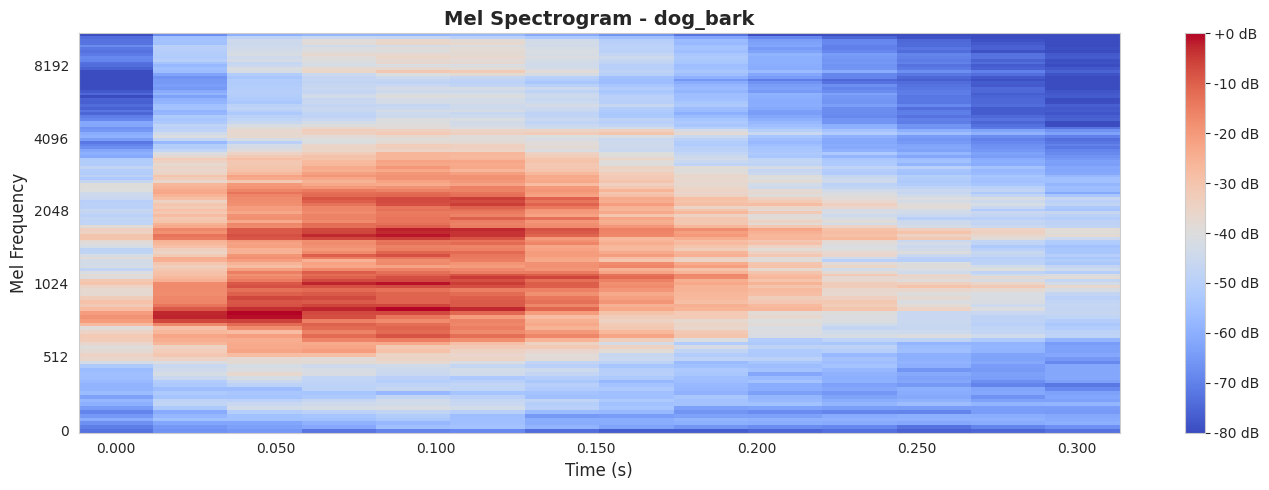

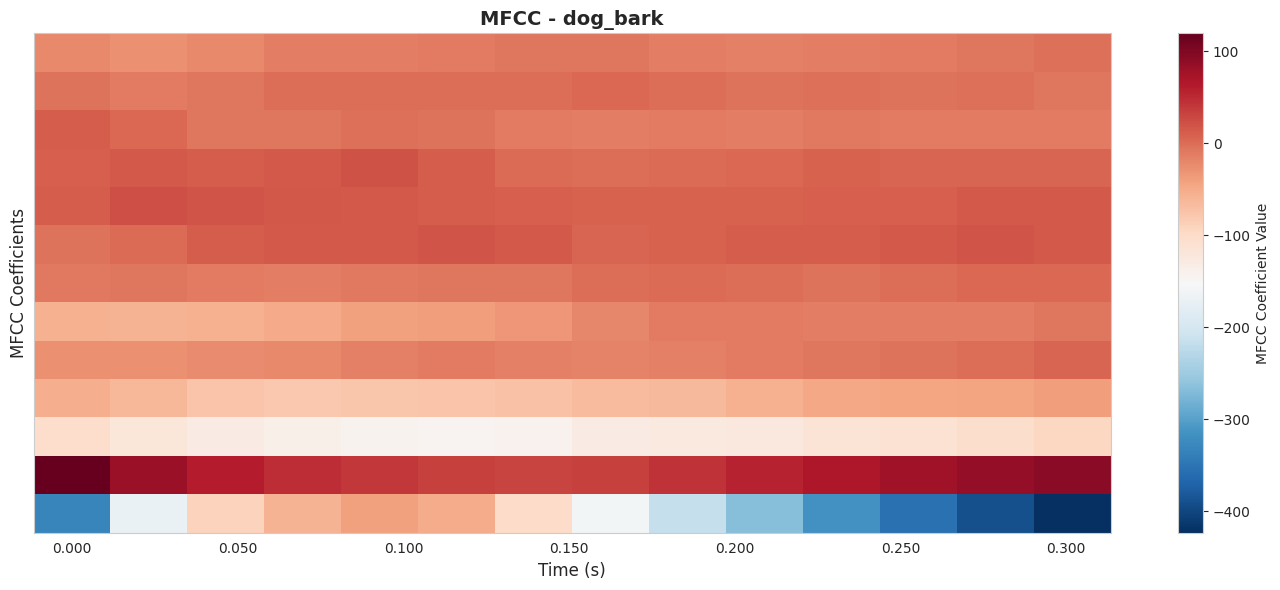

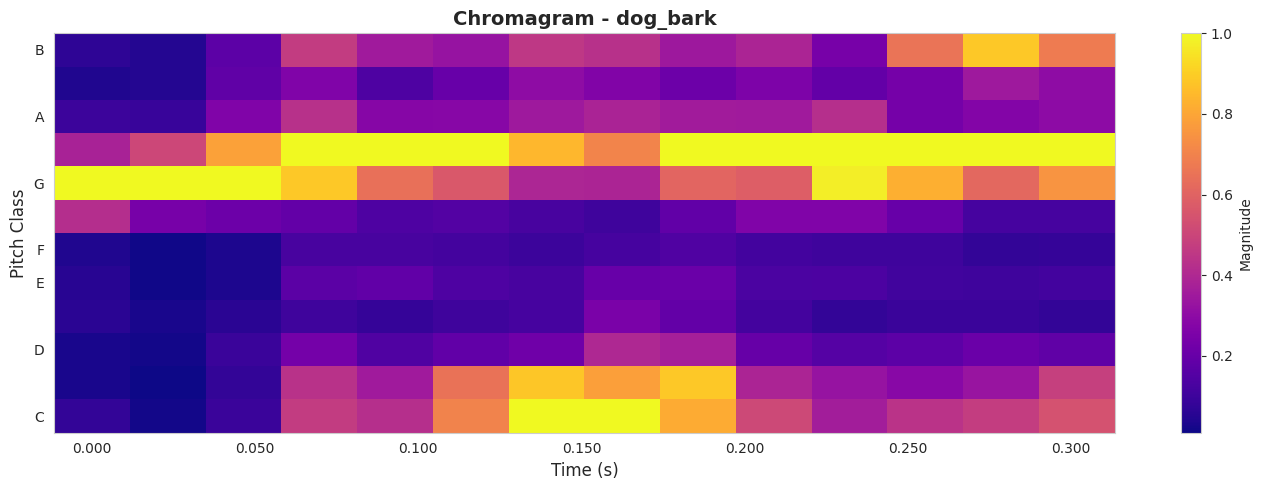

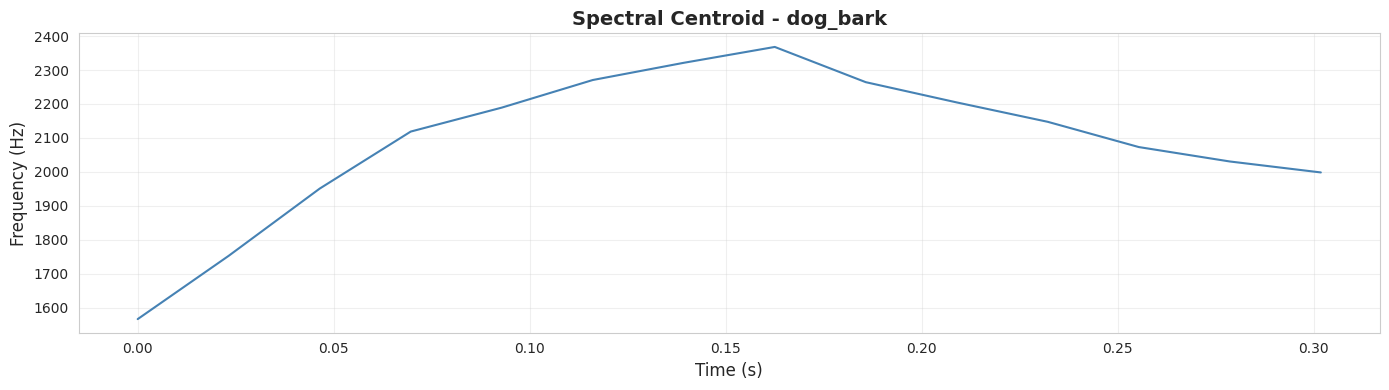

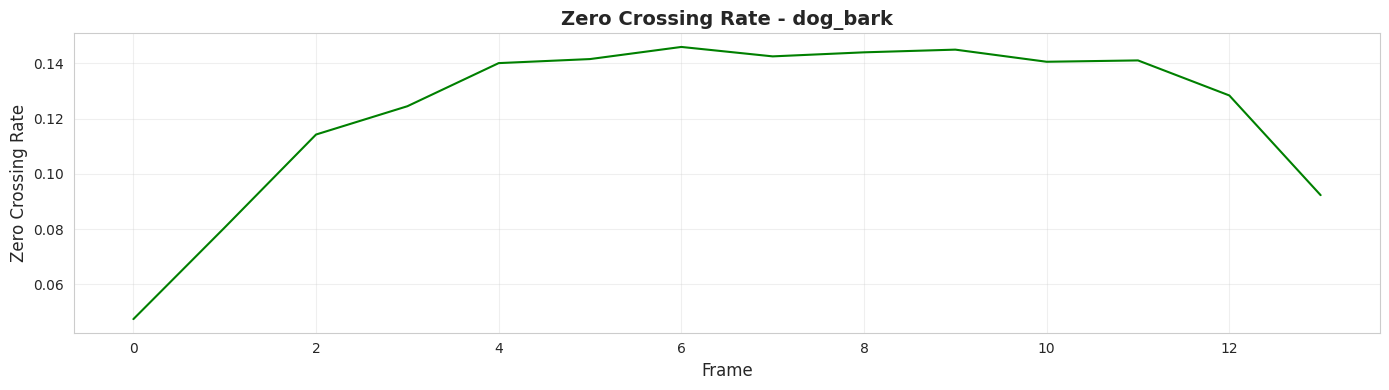

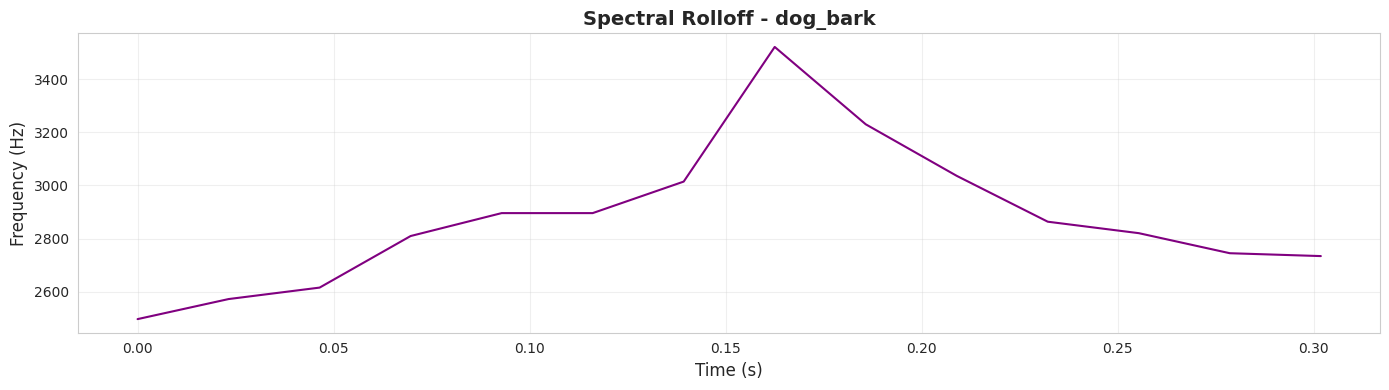

In [28]:
file_path, class_name = get_class_audio_path(df, AUDIO_BASE_PATH, 'dog_bark', index=0)
analyze_audio_comprehensive(file_path, class_name=class_name)


--- Sample 115 ---
File: 102853-8-0-0.wav


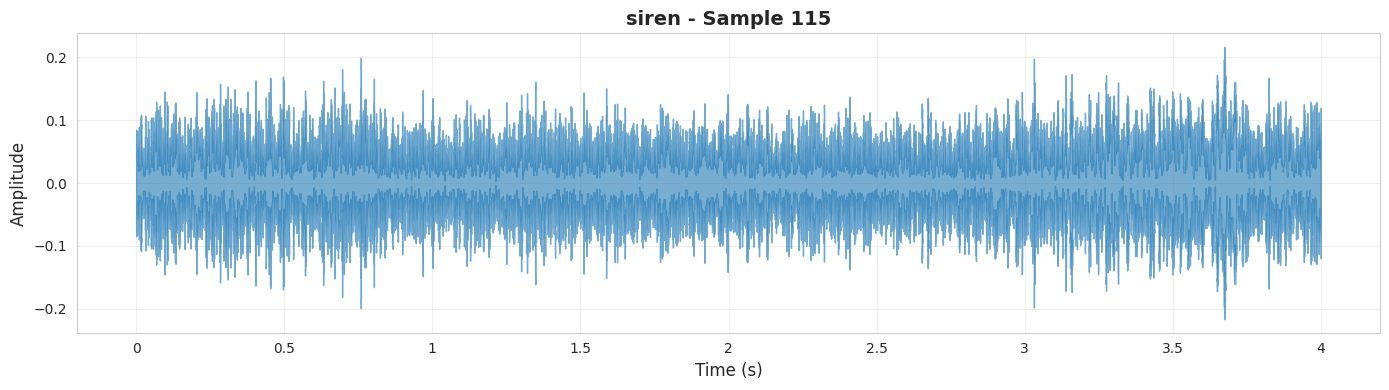

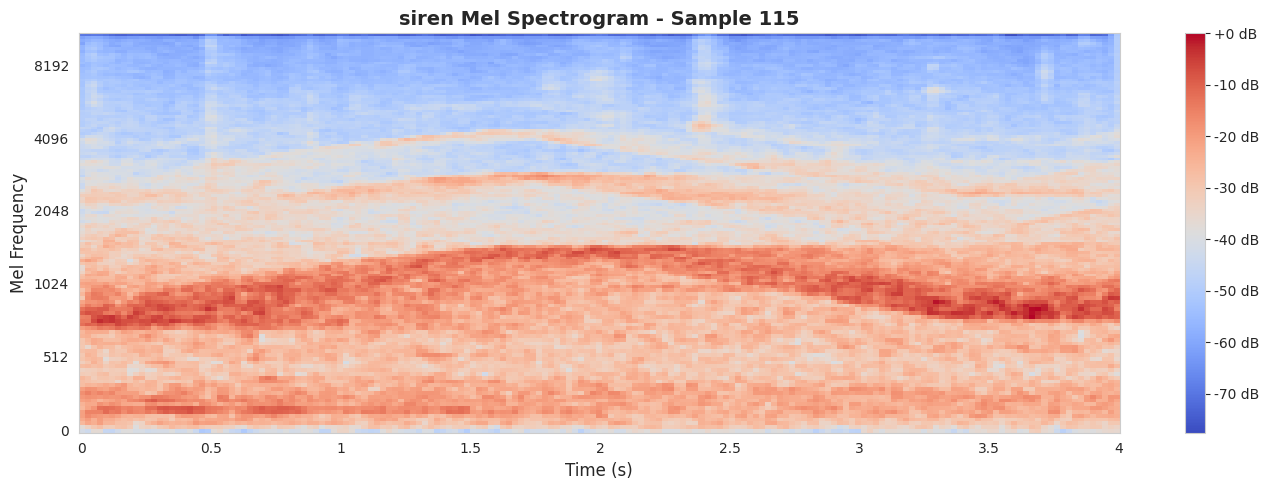


--- Sample 116 ---
File: 102853-8-0-1.wav


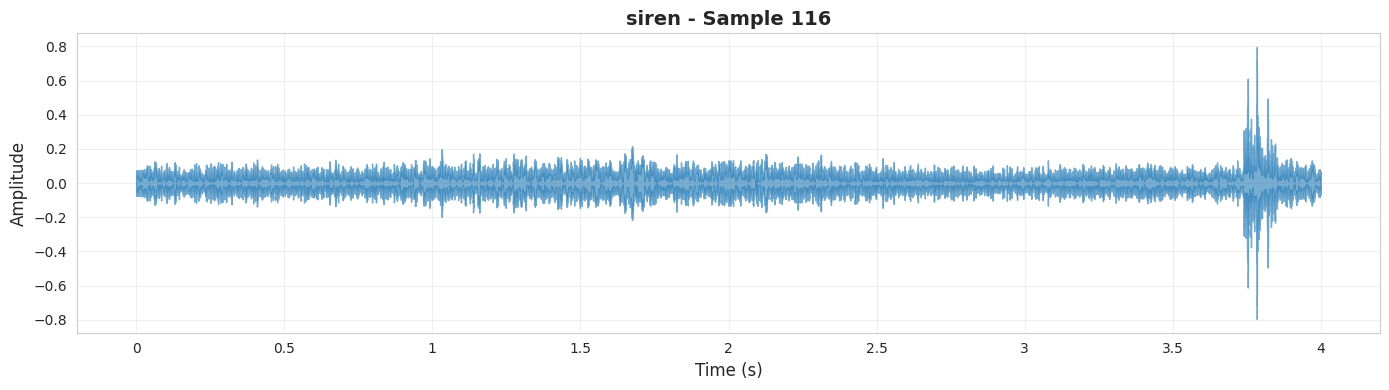

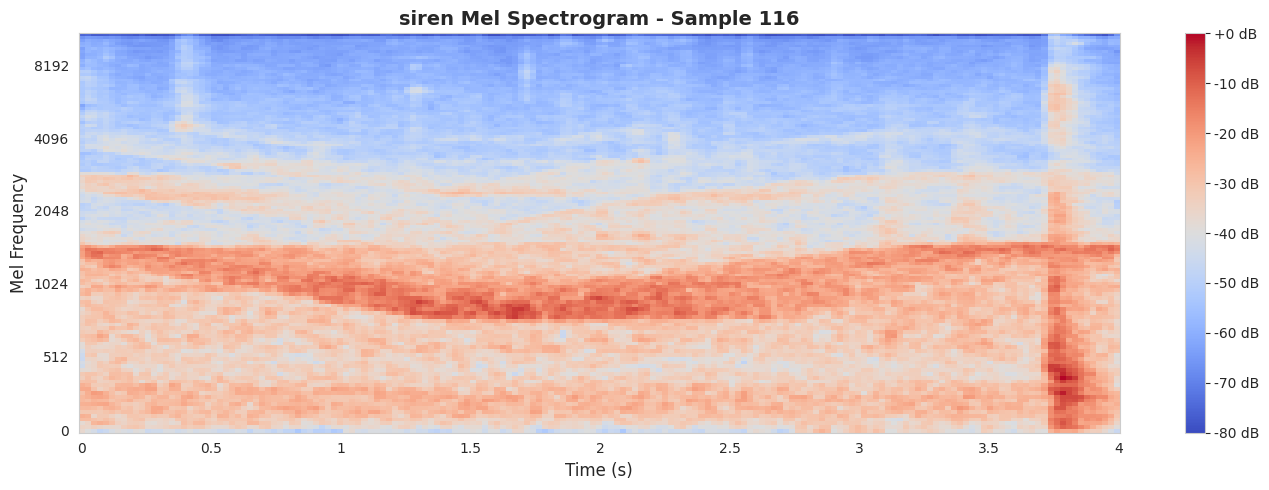


--- Sample 117 ---
File: 102853-8-0-2.wav


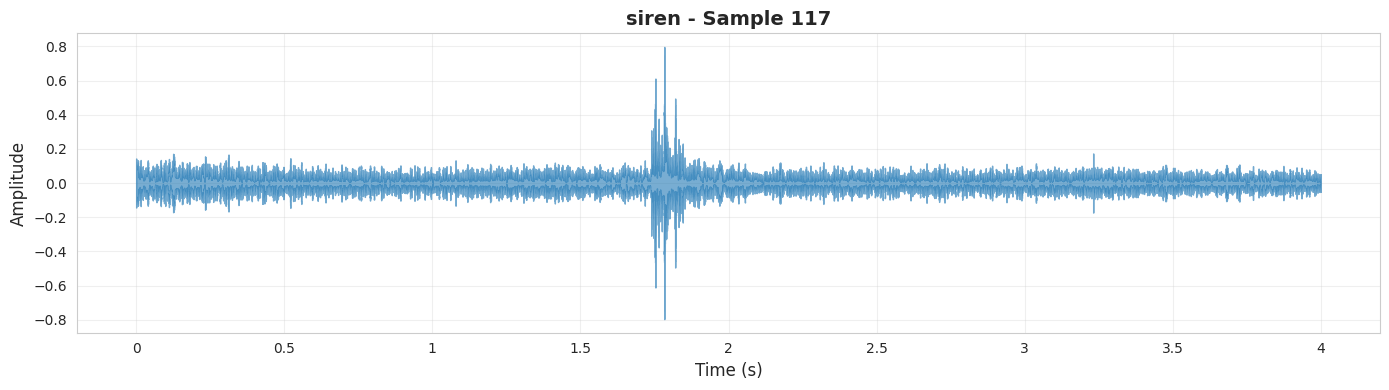

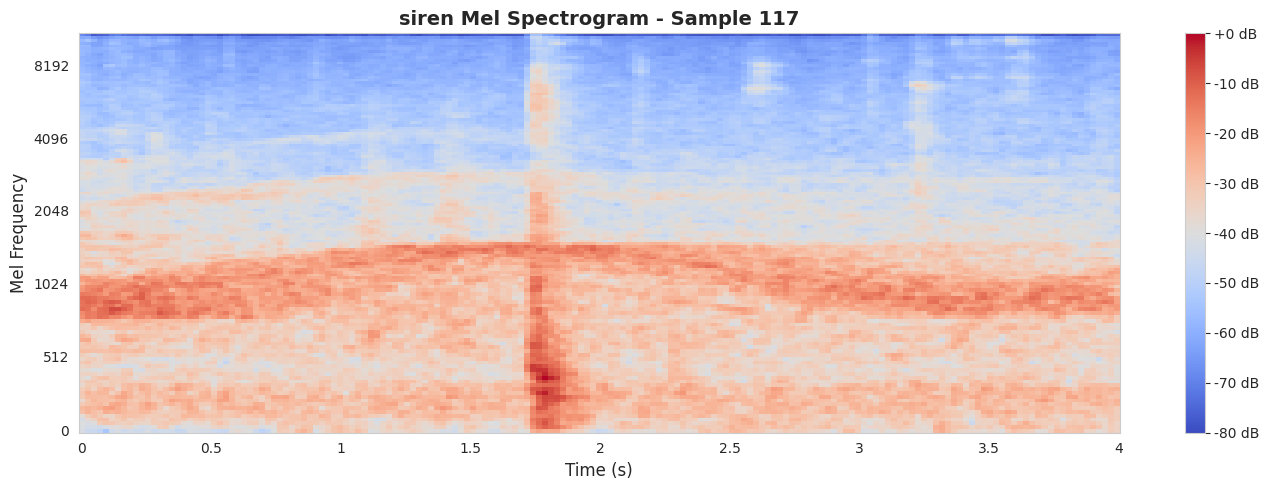

In [29]:
analyze_class_samples(df, 'UrbanSound8K/audio', 'siren', num_samples=3)

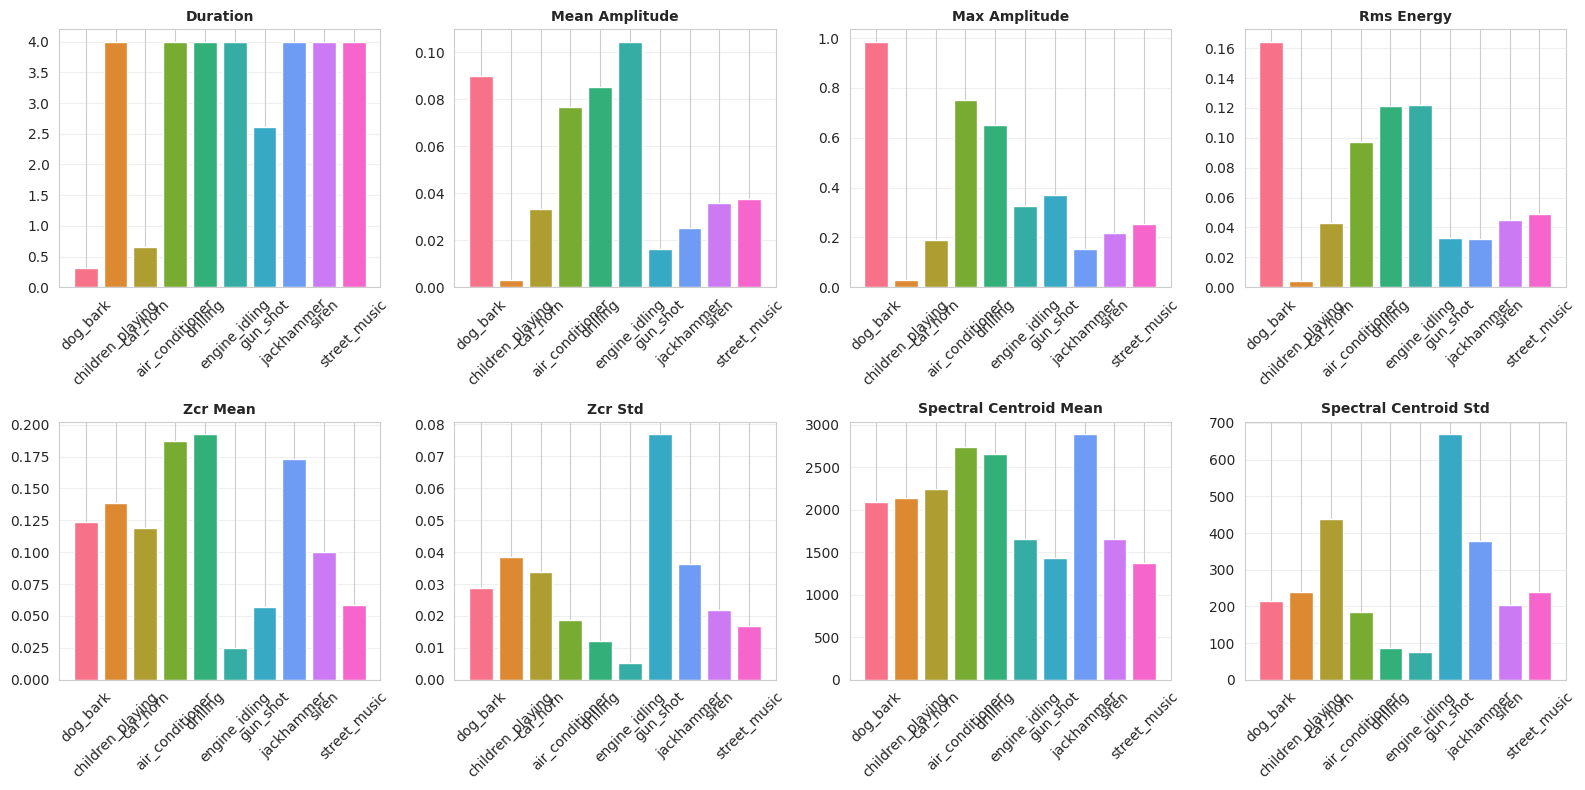

   duration  mean_amplitude  max_amplitude  rms_energy  zcr_mean   zcr_std  \
0  0.317551        0.090059       0.985863    0.164392  0.123465  0.028894   
1  4.000000        0.003199       0.027128    0.004148  0.138779  0.038332   
2  0.648526        0.033357       0.188049    0.043128  0.119106  0.033918   
3  4.000000        0.076732       0.750014    0.097175  0.186989  0.018589   
4  4.000000        0.085406       0.650571    0.121458  0.192583  0.012227   
5  4.000000        0.104634       0.325730    0.122160  0.024708  0.005243   
6  2.610023        0.016379       0.369727    0.032722  0.056943  0.076965   
7  4.000000        0.025449       0.155487    0.032329  0.173413  0.036320   
8  4.000000        0.035773       0.216774    0.045287  0.100501  0.021779   
9  4.000000        0.037689       0.254737    0.049055  0.058455  0.016838   

   spectral_centroid_mean  spectral_centroid_std  spectral_rolloff_mean  \
0             2089.849972             213.673961            2875.4

In [30]:
file_paths = []
class_names = []
for class_name in ['dog_bark', 'children_playing', 'car_horn', 'air_conditioner',
                   'drilling', 'engine_idling', 'gun_shot', 'jackhammer',  'siren', 'street_music']:
    fp, cn = get_class_audio_path(df, AUDIO_BASE_PATH, class_name, index=0)
    file_paths.append(fp)
    class_names.append(cn)

features_comparison = compare_classes_features(file_paths, class_names)
print(features_comparison)

The statistical analysis of the UrbanSound8K metadata reveals a significant class imbalance that must be addressed during model training.

As illustrated in the class distribution plot, while the majority of classes (such as 'jackhammer', 'engine_idling', and 'air_conditioner') contain approximately 1000 samples each, minority classes like 'car_horn' and 'gun_shot' typically contain fewer than 430 samples. This results in an imbalance ratio of approximately 2.3:1 between the majority and minority classes, which could bias the model toward the more frequent sounds.

Furthermore, the fold distribution shows slight variations in sample counts, requiring careful handling during cross-validation to ensure fair evaluation. These findings indicate that our data preparation pipeline must standardise the input signals not only in terms of sampling rate and duration but also potentially employ augmentation strategies to mitigate the scarcity of data in the minority classes.

# Data Preparation

In [31]:
def process_channels(audio, mode='mono'):
    """
    Process audio channels (mono/stereo/average)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio array, shape (samples,) or (samples, channels)
    mode : str
        'mono' - take first channel only
        'stereo' - convert to stereo (duplicate if mono)
        'avg' - average all channels
        'original' - keep as is
    
    Returns:
    --------
    np.ndarray : Processed audio
    """
    if mode == 'mono':
        new_audio = audio if audio.ndim == 1 else audio[:, :1]
    elif mode == 'stereo':
        new_audio = np.stack([audio]*2).T if audio.ndim == 1 else audio
    elif mode == 'avg':
        new_audio = audio.mean(axis=1) if audio.ndim > 1 else audio
        new_audio = new_audio[:, None]
    else:
        new_audio = audio
    return new_audio

In [32]:
def add_noise(audio, prob=0.5, noise_factor=0.005, noise_type='normal'):
    """
    Add random noise to audio signal
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying noise (0-1)
    noise_factor : float
        Standard deviation/range of noise
    noise_type : str
        'normal' - Gaussian noise
        'uniform' - Uniform noise
        'half' - Half-normal (non-negative) noise
    
    Returns:
    --------
    np.ndarray : Noisy audio
    """
    if np.random.rand() > prob:
        return audio
    
    length = audio.shape[0]
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, length)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, length)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, length)), 
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    noise = noise[:, None] if audio.ndim > 1 else noise
    return audio + noise.astype(np.float32)

In [33]:
def random_crop(audio, prob=0.5, max_crop_ratio=0.3):
    """
    Randomly crop audio to shorter duration
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying crop
    max_crop_ratio : float
        Maximum ratio to crop (0-0.9)
    
    Returns:
    --------
    np.ndarray : Cropped audio
    """
    if np.random.rand() > prob:
        return audio
    
    # Generate random crop ratio
    crop_ratio = np.random.uniform(0, max_crop_ratio)
    crop_ratio = np.clip(crop_ratio, 0, 0.9)
    
    # Calculate new length
    length = audio.shape[0]
    new_length = int(np.round(length * (1 - crop_ratio)))
    
    # Random start position
    max_start = length - new_length + 1
    ind_start = np.random.randint(0, max_start)
    ind_end = ind_start + new_length
    
    cropped = audio[ind_start:ind_end]
    
    # Avoid zero tensor
    if np.sum(np.abs(cropped)) == 0:
        cropped = cropped + 1e-8
    
    return cropped

In [34]:
def modify_duration(audio, target_duration):
    """
    Modify audio to target duration (crop or pad/repeat)
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    target_duration : int
        Target number of samples
    
    Returns:
    --------
    np.ndarray : Modified audio
    """
    current_length = len(audio)
    
    if target_duration < current_length:
        # Crop randomly
        max_index_start = current_length - target_duration
        index_start = np.random.randint(0, max_index_start + 1)
        index_end = index_start + target_duration
        new_audio = audio[index_start:index_end]
    else:
        # Pad by repeating
        ratio = target_duration / current_length
        full_reps = int(ratio)
        remaining = int(np.round(current_length * (ratio % 1)))
        
        repeated = [audio] * full_reps
        if remaining > 0:
            repeated.append(audio[:remaining])
        
        new_audio = np.concatenate(repeated, axis=0)
    
    return new_audio

In [35]:
def augment_audio(audio, prob=0.5, noise_factor=0.01, noise_type='uniform'):
    """
    Apply general augmentation 
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal
    prob : float
        Probability of applying augmentation
    noise_factor : float
        Magnitude of augmentation
    noise_type : str
        Type of noise distribution
    
    Returns:
    --------
    np.ndarray : Augmented audio
    """
    if np.random.rand() > prob:
        return audio
    
    if noise_type == 'normal':
        noise = np.random.normal(0, noise_factor, audio.shape)
    elif noise_type == 'uniform':
        noise = np.random.uniform(-noise_factor, noise_factor, audio.shape)
    elif noise_type == 'half':
        noise = np.clip(np.abs(np.random.normal(0, noise_factor, audio.shape)),
                       a_min=0.0, a_max=0.8)
    else:
        raise ValueError(f'Unknown noise type: {noise_type}')
    
    return audio + noise.astype(np.float32)

def _pitch_shift(audio, sr, n_steps):
    return librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

def _time_stretch(audio, rate):
    return librosa.effects.time_stretch(audio, rate=rate)

In [36]:
import random
import uuid

def balance_raw_data_with_augmentation(df_train_fold, audio_base_path, sr):
    """
    Tackles class imbalance by generating raw audio samples for minority classes
    using noise, pitch shift, and time stretch.

    Returns:
        A DataFrame with the EXACT SAME STRUCTURE as df_train_fold, 
        plus 'is_augmented' flag, where augmented samples have new filenames.
    """
    original_columns = df_train_fold.columns.tolist()

    class_counts = df_train_fold['class'].value_counts()
    majority_count = class_counts.max()

    minority_df = df_train_fold[df_train_fold['class'].apply(lambda x: class_counts[x] < majority_count)]

    augmented_rows = []
    minority_groups = minority_df.groupby('class')

    for cls, group_df in minority_groups:
        current_count = len(group_df)
        samples_to_generate = majority_count - current_count

        original_samples = []
        original_rows = []

        for _, row in group_df.iterrows():
            file_path = os.path.join(
                audio_base_path,
                f"fold{row['fold']}",
                row['slice_file_name']
            )

            try:
                audio, _ = load_audio(file_path, sr=sr)
                original_samples.append(audio)
                original_rows.append(row)

            except Exception:
                continue

        if not original_samples:
            continue

        for _ in range(samples_to_generate):
            # pick a random row to copy metadata from
            idx = random.randint(0, len(original_samples) - 1)
            original_audio = original_samples[idx]
            original_row = original_rows[idx]

            tech = random.choice(['noise', 'pitch_shift', 'time_stretch'])

            if tech == 'noise':
                augmented_audio = augment_audio(
                    original_audio,
                    prob=1.0,
                    noise_factor=random.uniform(0.005, 0.05),
                    noise_type=random.choice(['normal', 'uniform'])
                )

            elif tech == 'pitch_shift':
                augmented_audio = _pitch_shift(
                    original_audio, sr, n_steps=random.uniform(-3, 3)
                )

            elif tech == 'time_stretch':
                augmented_audio = _time_stretch(
                    original_audio, rate=random.uniform(0.8, 1.2)
                )

            new_filename = f"aug_{uuid.uuid4().hex[:8]}.wav"

            save_path = os.path.join(
                audio_base_path,
                f"fold{original_row['fold']}",
                new_filename
            )

            sf.write(save_path, augmented_audio, sr)

            new_row = original_row.copy()
            new_row['slice_file_name'] = new_filename
            new_row['is_augmented'] = True

            augmented_rows.append(new_row)

    if len(augmented_rows) > 0:
        df_aug = pd.DataFrame(augmented_rows)

        for col in original_columns:
            if col not in df_aug.columns:
                df_aug[col] = None

        out_df = pd.concat([df_train_fold, df_aug], ignore_index=True)

        cols = original_columns + (['is_augmented'] if 'is_augmented' in out_df else [])
        out_df = out_df[cols]

        return out_df

    df_train_fold['is_augmented'] = False
    return df_train_fold

In [37]:
def preprocess_audio_pipeline(audio, mode='train', 
                              channel_mode='mono',
                              noise_prob=0.5, noise_factor=0.005, noise_type='normal',
                              crop_prob=0.5, max_crop_ratio=0.3,
                              augment_prob=0.5, augment_factor=0.01, augment_type='uniform',
                              target_duration=None):
    """
    Complete preprocessing pipeline for audio
    
    Parameters:
    -----------
    audio : np.ndarray
        Audio signal from librosa.load
    mode : str
        'train' - Apply all augmentations
        'val' or 'test' - Only channel processing
    channel_mode : str
        Channel processing mode
    noise_prob, noise_factor, noise_type : 
        Parameters for additive noise
    crop_prob, max_crop_ratio :
        Parameters for random cropping
    augment_prob, augment_factor, augment_type :
        Parameters for general augmentation
    target_duration : int or None
        If specified, resize to this many samples
    
    Returns:
    --------
    np.ndarray : Preprocessed audio
    """
    # Ensure 2D shape (samples, channels)
    if audio.ndim == 1:
        audio = audio[:, None]
    
    # Step 1: Process channels
    audio = process_channels(audio, mode=channel_mode)
    
    if mode == 'train':
        # Step 2: Add noise
        audio = add_noise(audio, prob=noise_prob, 
                         noise_factor=noise_factor, 
                         noise_type=noise_type)
        
        # Step 3: Random crop
        audio = random_crop(audio, prob=crop_prob, 
                           max_crop_ratio=max_crop_ratio)
        
        # Step 4: General augmentation
        audio = augment_audio(audio, prob=augment_prob,
                            noise_factor=augment_factor,
                            noise_type=augment_type)
    
    # Step 5: Modify duration if specified
    if target_duration is not None:
        audio = modify_duration(audio, target_duration)
    
    return audio

In [38]:
import sys 
import os
import numpy as np
import pandas as pd

def preprocess_and_cache_folds(df, audio_base_path, save_dir="data_cache", sr=22050, config=None):
    """
        Preprocesses each fold in BOTH 'train' and 'test' modes and saves them separately.
    
    - 'train' mode utilizes balance_raw_data_with_augmentation to create and use 
      a balanced, augmented dataset for the fold.
    """
    os.makedirs(save_dir, exist_ok=True)
    
    target_duration = config.get('target_samples', 88200) if config else 88200
    channel_mode = config.get('channel_mode', 'mono') if config else 'mono'

    print(f"Preprocessing dataset into {save_dir}...")

    processing_modes = ['train', 'test']

    for fold in range(1, 11):
        print(f"\nProcessing Fold {fold}...")
        
        fold_df = df[df['fold'] == fold].copy()
        
        for mode in processing_modes:
            if mode == 'train':
                process_df = balance_raw_data_with_augmentation(
                    df_train_fold=fold_df, 
                    audio_base_path=audio_base_path, 
                    sr=sr
                )
                print(f"  [{mode}] Samples: {len(fold_df)} originals + {len(process_df) - len(fold_df)} augmented = {len(process_df)} total")

            else:
                process_df = fold_df.copy()
                print(f"  [{mode}] Samples: {len(process_df)} original (no balancing)")

            fold_audio = []
            fold_labels = []
            fold_filenames = []
            
            save_path = os.path.join(save_dir, f"fold_{fold}_{mode}.npz")
            if os.path.exists(save_path):
                print(f"  [{mode}] already exists, skipping...")
                continue
            
            for _, row in process_df.iterrows():
                file_path = os.path.join(audio_base_path, f"fold{fold}", row['slice_file_name'])
                
                try:
                    y, _ = load_audio(file_path, sr=sr)
                    
                    y_proc = preprocess_audio_pipeline(
                        y, 
                        mode=mode, 
                        channel_mode=channel_mode,
                        target_duration=target_duration
                    )
                    
                    fold_audio.append(y_proc)
                    
                    fold_labels.append(row['class']) 
                    fold_filenames.append(row['slice_file_name'])

                except Exception as e:
                    print(f"\n[CRITICAL ERROR] Failed to process {row['slice_file_name']} (Fold {fold}, Mode {mode}): {e}")
                    continue
            
            if len(fold_audio) > 0:
                fold_audio = np.array(fold_audio)
                fold_labels = np.array(fold_labels)
                np.savez(save_path, audio=fold_audio, labels=fold_labels, filenames=fold_filenames)
                print(f"  [{mode}] Saved: {fold_audio.shape} samples to {save_path}")

In [39]:
def load_folds_data(fold_indices, mode, data_dir="data_cache"):
    """
    Loads specific folds in the specified mode ('train' or 'test').
    
    Usage:
        train_X, train_y = load_folds_data([1,2,3], mode='train')
        val_X, val_y     = load_folds_data([4], mode='test')
    """
    all_audio = []
    all_labels = []
    
    for fold in fold_indices:
        filename = f"fold_{fold}_{mode}.npz"
        path = os.path.join(data_dir, filename)
        
        if not os.path.exists(path):
            raise FileNotFoundError(f"File {filename} not found in {data_dir}")
            
        data = np.load(path, allow_pickle=True)
        all_audio.append(data['audio'])
        all_labels.append(data['labels'])
    
    if not all_audio:
        return np.array([]), np.array([])
        
    return np.concatenate(all_audio, axis=0), np.concatenate(all_labels, axis=0)

In [40]:
def visualize_preprocessing_comparison(original_audio, processed_audio, sr, 
                                      original_label="Original", 
                                      processed_label="Processed"):
    """
    Visualize original vs preprocessed audio
    
    Parameters:
    -----------
    original_audio : np.ndarray
        Original audio signal
    processed_audio : np.ndarray
        Preprocessed audio signal
    sr : int
        Sample rate
    original_label, processed_label : str
        Labels for plots
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    
    # Flatten for mono comparison
    orig = original_audio.flatten() if original_audio.ndim > 1 else original_audio
    proc = processed_audio.flatten() if processed_audio.ndim > 1 else processed_audio
    
    # Waveforms
    librosa.display.waveshow(orig, sr=sr, ax=axes[0, 0], alpha=0.6, color='blue')
    axes[0, 0].set_title(f'Waveform - {original_label}', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Time (s)')
    axes[0, 0].set_ylabel('Amplitude')
    
    librosa.display.waveshow(proc, sr=sr, ax=axes[0, 1], alpha=0.6, color='red')
    axes[0, 1].set_title(f'Waveform - {processed_label}', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Time (s)')
    axes[0, 1].set_ylabel('Amplitude')
    
    # Spectrograms
    D_orig = librosa.amplitude_to_db(np.abs(librosa.stft(orig)), ref=np.max)
    D_proc = librosa.amplitude_to_db(np.abs(librosa.stft(proc)), ref=np.max)
    
    img1 = librosa.display.specshow(D_orig, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 0], cmap='viridis')
    axes[1, 0].set_title(f'Spectrogram - {original_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img1, ax=axes[1, 0], format='%+2.0f dB')
    
    img2 = librosa.display.specshow(D_proc, sr=sr, x_axis='time', y_axis='hz', 
                                     ax=axes[1, 1], cmap='viridis')
    axes[1, 1].set_title(f'Spectrogram - {processed_label}', fontsize=12, fontweight='bold')
    fig.colorbar(img2, ax=axes[1, 1], format='%+2.0f dB')
    
    plt.tight_layout()
    plt.show()

In [41]:
def analyze_preprocessing_effects(df, audio_base_path, num_samples=5, sr=22050):
    """
    Analyze effects of different preprocessing techniques
    
    Parameters:
    -----------
    df : pd.DataFrame
        Metadata dataframe
    audio_base_path : str
        Path to audio files
    num_samples : int
        Number of samples to analyze
    sr : int
        Sample rate
    """
    print("Analyzing preprocessing effects on sample audios...\n")
    
    for i in range(min(num_samples, len(df))):
        row = df.iloc[i]
        file_path = os.path.join(audio_base_path, f"fold{row['fold']}", row['slice_file_name'])
        
        if not os.path.exists(file_path):
            continue
        
        # Load original
        y_orig, _ = librosa.load(file_path, sr=sr)
        
        print(f"\n{'='*60}")
        print(f"Sample {i+1}: {row['class']} - {row['slice_file_name']}")
        print(f"{'='*60}")
        print(f"Original shape: {y_orig.shape}")
        print(f"Original duration: {len(y_orig)/sr:.2f}s")
        
        # Apply different preprocessing
        y_noise = add_noise(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                           prob=1.0, noise_factor=0.01)
        print(f"After noise: shape {y_noise.shape}")
        
        y_crop = random_crop(y_orig[:, None] if y_orig.ndim == 1 else y_orig, 
                            prob=1.0, max_crop_ratio=0.3)
        print(f"After crop: shape {y_crop.shape}, duration {len(y_crop)/sr:.2f}s")
        
        y_full = preprocess_audio_pipeline(y_orig, mode='train', 
                                          channel_mode='mono',
                                          noise_prob=1.0, crop_prob=1.0, 
                                          augment_prob=1.0)
        print(f"After full pipeline: shape {y_full.shape}")
        
        # Visualize
        visualize_preprocessing_comparison(y_orig, y_full.flatten(), sr,
                                          original_label=f"Original - {row['class']}",
                                          processed_label="Fully Preprocessed")

Analyzing preprocessing effects on sample audios...


Sample 1: dog_bark - 100032-3-0-0.wav
Original shape: (7002,)
Original duration: 0.32s
After noise: shape (7002, 1)
After crop: shape (5806, 1), duration 0.26s
After full pipeline: shape (5603, 1)


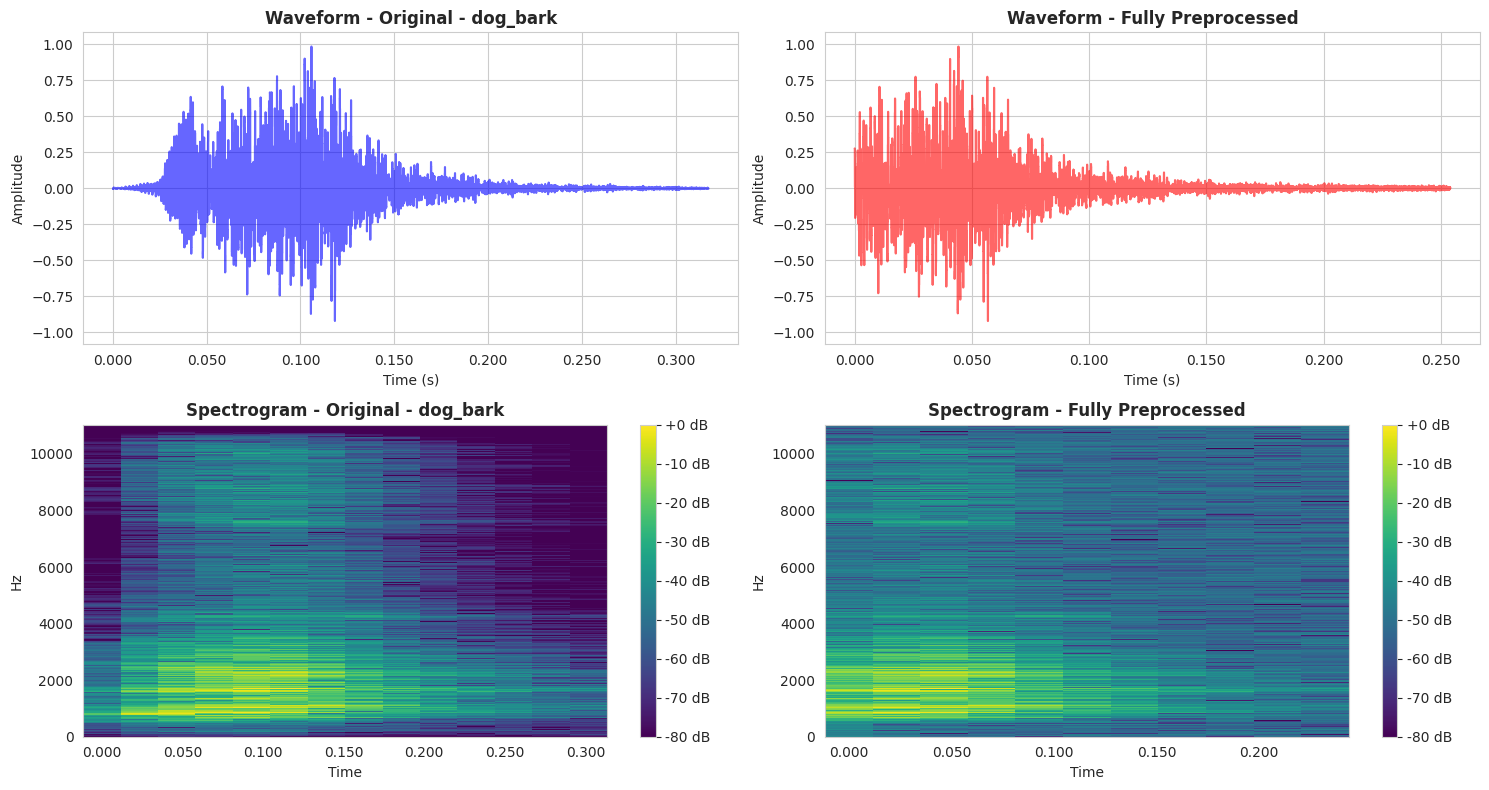


Sample 2: children_playing - 100263-2-0-117.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (68801, 1), duration 3.12s
After full pipeline: shape (67417, 1)


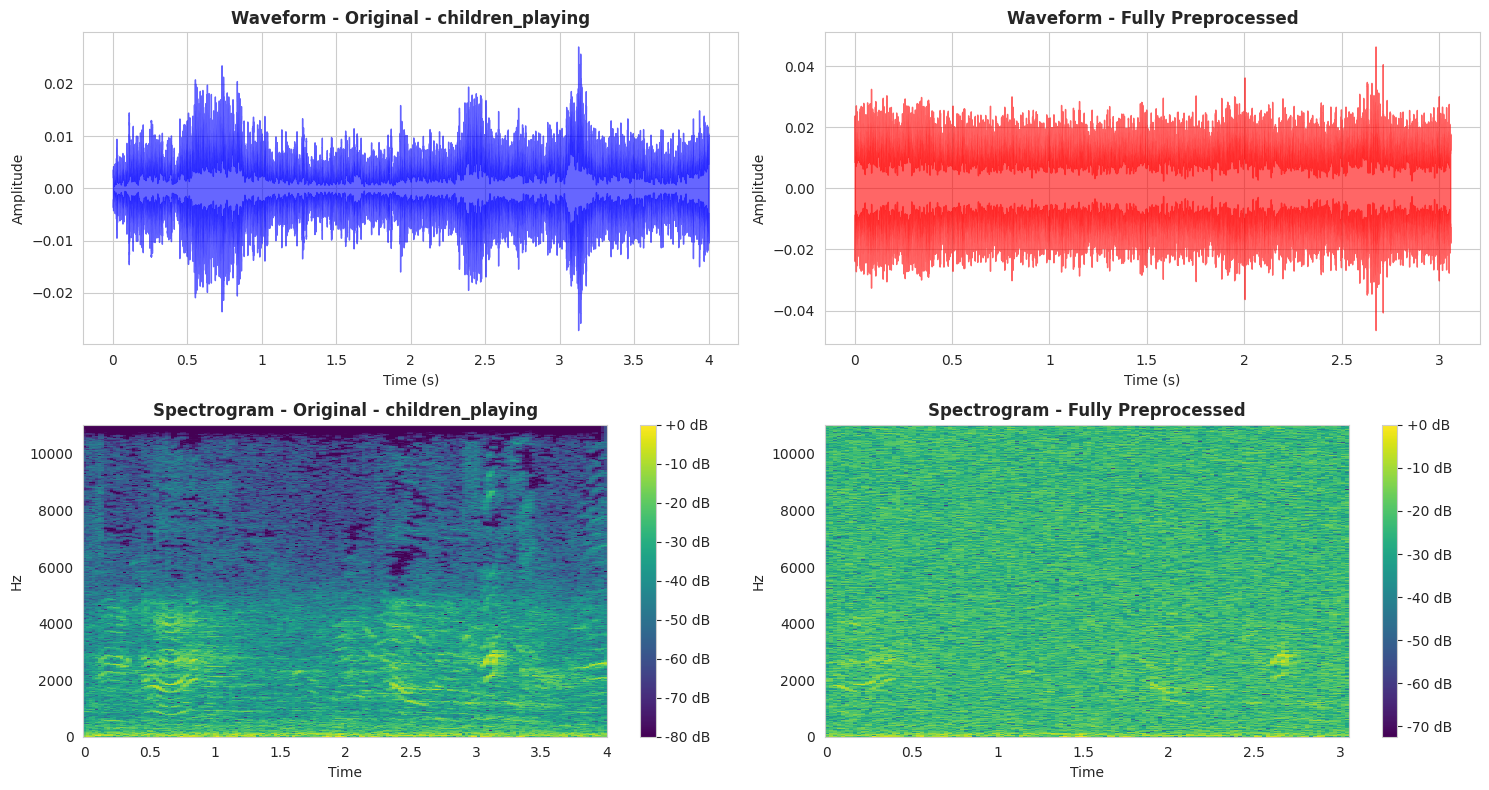


Sample 3: children_playing - 100263-2-0-121.wav
Original shape: (88200,)
Original duration: 4.00s
After noise: shape (88200, 1)
After crop: shape (69175, 1), duration 3.14s
After full pipeline: shape (62740, 1)


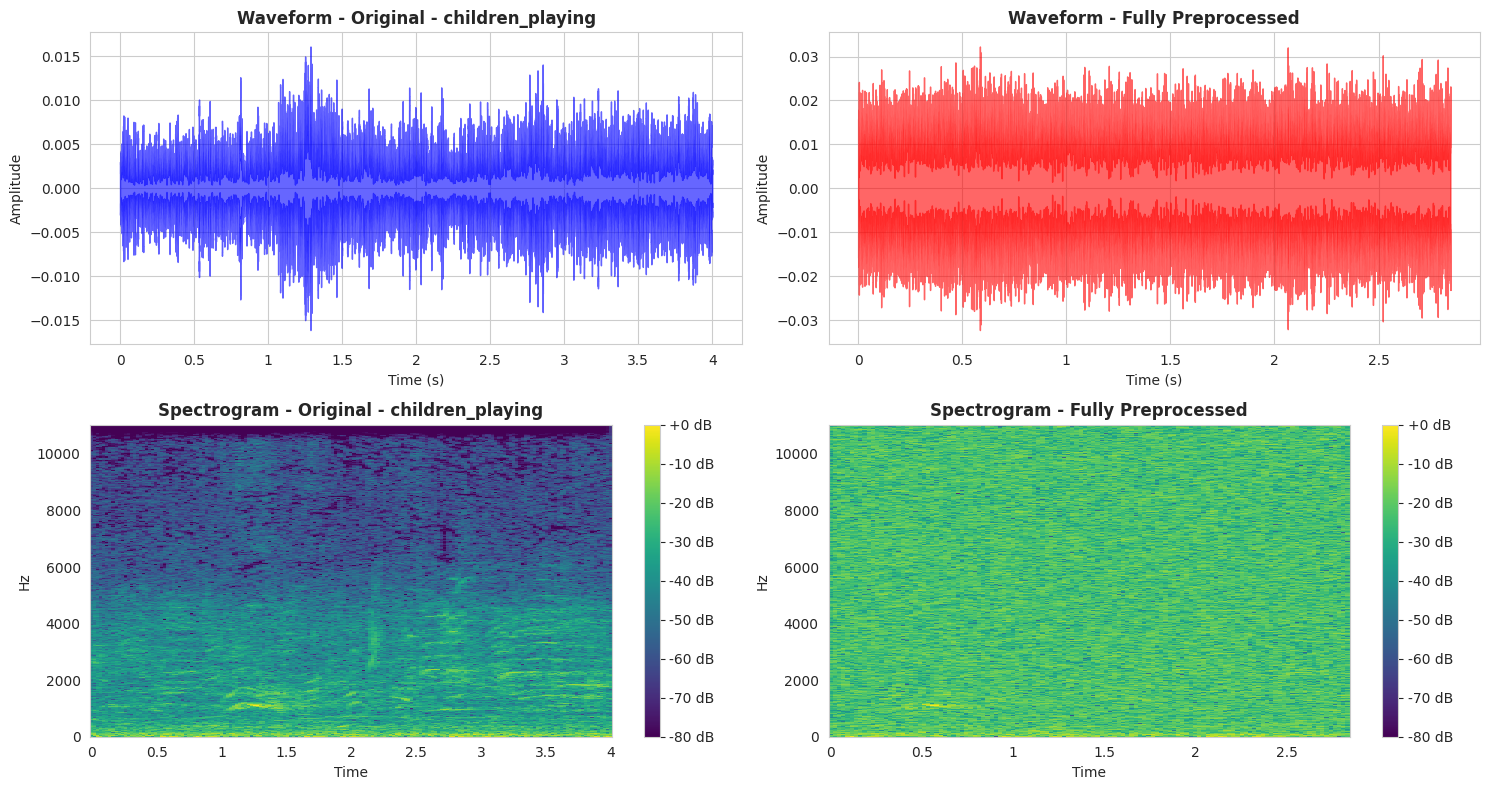

In [42]:
analyze_preprocessing_effects(df, AUDIO_BASE_PATH, num_samples=3, sr=22050)

In [43]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from collections import defaultdict

In [44]:
class AudioDataset(Dataset):
    """
    Dataset class for audio data
    """
    def __init__(self, audio_data, labels, transform=None):
        """
        Parameters:
        -----------
        audio_data : list or np.ndarray
            List of audio arrays
        labels : list or np.ndarray
            Corresponding labels
        transform : callable, optional
            Optional transform to apply
        """
        self.audio_data = audio_data
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.audio_data)
    
    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        
        # Convert to tensor if not already
        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)
        
        if not isinstance(label, torch.Tensor):
            label = torch.LongTensor([label])[0]
        
        if self.transform:
            audio = self.transform(audio)
        
        return audio, label

In [45]:
def accuracy(output, target):
    """Calculate accuracy"""
    with torch.no_grad():
        pred = torch.argmax(output, dim=1)
        assert pred.shape[0] == len(target)
        correct = torch.sum(pred == target).item()
    return correct / len(target)

def top_k_accuracy(output, target, k=3):
    """Calculate top-k accuracy"""
    with torch.no_grad():
        pred = torch.topk(output, k, dim=1)[1]
        assert pred.shape[0] == len(target)
        correct = 0
        for i in range(k):
            correct += torch.sum(pred[:, i] == target).item()
    return correct / len(target)

In [46]:
def evaluate_model(model, test_dataset, batch_size=32, device=None, metrics=None):
    """
    Evaluate model on test dataset
    
    Parameters:
    -----------
    model : nn.Module
        Trained model
    test_dataset : Dataset or dict
        Test dataset
    batch_size : int
        Batch size
    device : str or torch.device, optional
        Device to use
    metrics : list of callable, optional
        Metrics to compute
    
    Returns:
    --------
    dict : Evaluation results
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    
    # Convert dict to Dataset if needed
    if isinstance(test_dataset, dict):
        test_dataset = AudioDataset(test_dataset['audio'], test_dataset['labels'])
    
    # Create data loader
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=0
    )
    
    # Setup metrics
    if metrics is None:
        metrics = [accuracy]
    
    model.eval()
    total_metrics = np.zeros(len(metrics))
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for data, target in tqdm(test_loader, desc='Evaluating'):
            data, target = data.to(device), target.to(device)
            
            output = model(data)
            
            # Track metrics
            for i, metric in enumerate(metrics):
                total_metrics[i] += metric(output, target)
            
            # Store predictions
            pred = torch.argmax(output, dim=1)
            all_predictions.extend(pred.cpu().numpy())
            all_targets.extend(target.cpu().numpy())
    
    # Calculate average metrics
    avg_metrics = total_metrics / len(test_loader)
    
    results = {
        'predictions': np.array(all_predictions),
        'targets': np.array(all_targets)
    }
    
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        results[metric_name] = avg_metrics[i]
    
    print("\nEvaluation Results:")
    print("=" * 40)
    for i, metric in enumerate(metrics):
        metric_name = metric.__name__ if hasattr(metric, '__name__') else f'metric_{i}'
        print(f"{metric_name}: {avg_metrics[i]:.4f}")
    print("=" * 40)
    
    return results

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os

from torch.utils.data import Dataset, DataLoader
from torchaudio.transforms import Spectrogram, MelSpectrogram, TimeStretch, AmplitudeToDB
from torch.distributions import Uniform
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime

In [48]:
def _num_stft_bins(lengths, fft_length, hop_length, pad):
    return (lengths + 2 * pad - fft_length + hop_length) // hop_length

class RandomTimeStretch(TimeStretch):
    def __init__(self, max_perc, hop_length=None, n_freq=201, fixed_rate=None):
        super(RandomTimeStretch, self).__init__(hop_length, n_freq, fixed_rate)
        self._dist = Uniform(1.-max_perc, 1+max_perc)

    def forward(self, x):
        rate = self._dist.sample().item()
        return super(RandomTimeStretch, self).forward(x, rate), rate

class SpecNormalization(nn.Module):
    def __init__(self, norm_type, top_db=80.0):
        super(SpecNormalization, self).__init__()

        if 'db' == norm_type:
            self._norm = AmplitudeToDB(stype='power', top_db=top_db)
        elif 'whiten' == norm_type:
            self._norm = lambda x: self.z_transform(x)
        else:
            self._norm = lambda x: x
        
    def z_transform(self, x):
        # Independent mean, std per batch
        non_batch_inds = [1, 2, 3]
        mean = x.mean(non_batch_inds, keepdim=True)
        std = x.std(non_batch_inds, keepdim=True)
        x = (x - mean)/std 
        return x

    def forward(self, x):
        return self._norm(x)

class MelspectrogramStretch(MelSpectrogram):
    def __init__(self, hop_length=None, 
                       sample_rate=44100, 
                       num_mels=128, 
                       fft_length=2048, 
                       norm='whiten', 
                       stretch_param=[0.4, 0.4]):

        super(MelspectrogramStretch, self).__init__(sample_rate=sample_rate, 
                                                    n_fft=fft_length, 
                                                    hop_length=hop_length, 
                                                    n_mels=num_mels)

        self.stft = Spectrogram(n_fft=self.n_fft, win_length=self.win_length,
                                       hop_length=self.hop_length, pad=self.pad, 
                                       power=None, normalized=False)

        # Augmentation
        self.prob = stretch_param[0]
        self.random_stretch = RandomTimeStretch(stretch_param[1], 
                                                self.hop_length, 
                                                self.n_fft//2+1, 
                                                fixed_rate=None)
        
        # Normalization (post spec processing)
        self.complex_norm = lambda x: torch.abs(x).pow(2.0)
        self.norm = SpecNormalization(norm)

    def forward(self, x, lengths=None):
        x = self.stft(x)

        if lengths is not None:
            lengths = _num_stft_bins(lengths, self.n_fft, self.hop_length, self.n_fft//2)
            lengths = lengths.long()
        
        if torch.rand(1)[0] <= self.prob and self.training:
            # Stretch spectrogram in time using Phase Vocoder
            x, rate = self.random_stretch(x)
            # Modify the rate accordingly
            lengths = (lengths.float()/rate).long()+1
        
        x = self.complex_norm(x)
        x = self.mel_scale(x)

        # Normalize melspectrogram
        x = self.norm(x)

        if lengths is not None:
            return x, lengths        
        return x

    def __repr__(self):
        return self.__class__.__name__ + '()'

In [49]:
class AudioRNN(nn.Module):
    def __init__(self, num_classes=10, config=None):
        super(AudioRNN, self).__init__()
        
        self.num_classes = num_classes
        self.config = config if config else {}
        
        # Spectrogram parameters
        self.sample_rate = self.config.get('sample_rate', 22050)
        self.num_mels = self.config.get('num_mels', 128)
        self.fft_length = self.config.get('fft_length', 2048)
        self.hop_length = self.config.get('hop_length', 512)
        
        # Melspectrogram transform
        self.spec = MelspectrogramStretch(
            hop_length=self.hop_length,
            sample_rate=self.sample_rate,
            num_mels=self.num_mels,
            fft_length=self.fft_length,
            norm=self.config.get('norm', 'whiten'),
            stretch_param=self.config.get('stretch_param', [0.4, 0.4])
        )
        
        # RNN parameters
        self.hidden_size = self.config.get('hidden_size', 64)
        self.num_layers = self.config.get('num_layers', 2)
        self.bidirectional = self.config.get('bidirectional', False)
        self.rnn_dropout = self.config.get('rnn_dropout', 0.1)
        
        # Build LSTM
        self.lstm = nn.LSTM(
            input_size=self.num_mels,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            bidirectional=self.bidirectional,
            dropout=self.rnn_dropout if self.num_layers > 1 else 0.0,
            batch_first=True
        )
        
        # Dense layer parameters
        lstm_output_size = self.hidden_size * (2 if self.bidirectional else 1)
        self.dropout_p = self.config.get('dropout', 0.3)
        
        # Build dense layers
        self.dense = nn.Sequential(
            nn.Dropout(self.dropout_p),
            nn.LayerNorm(lstm_output_size),
            nn.Linear(lstm_output_size, num_classes)
        )
    
    def _many_to_one(self, t, lengths):
        """Extract last relevant output for each sequence"""
        return t[torch.arange(t.size(0)), lengths - 1]
    
    def forward(self, x, lengths=None):
        """
        Args:
            x: (batch, time) audio waveform
            lengths: (batch,) sequence lengths
        """
        # Ensure correct shape
        if x.dim() == 2:
            x = x.unsqueeze(1)  # (batch, 1, time)
        
        # Spectrogram: (batch, channel, freq, time)
        x, lengths = self.spec(x, lengths)
        
        # Transpose to (batch, time, channel, freq)
        x = x.transpose(1, -1)
        batch_size, time = x.size()[:2]
        
        # Flatten: (batch, time, features)
        x = x.reshape(batch_size, time, -1)
        
        # Pack padded sequence
        x_pack = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        # LSTM
        x_pack, _ = self.lstm(x_pack)
        
        # Unpack
        x, _ = nn.utils.rnn.pad_packed_sequence(x_pack, batch_first=True)
        
        # Many-to-one
        x = self._many_to_one(x, lengths)
        
        # Dense layers
        x = self.dense(x)
        
        return F.log_softmax(x, dim=1)

class AudioRNNDataset(Dataset):
    def __init__(self, audio_data, labels):
        self.audio_data = audio_data
        
        if labels.dtype.kind in ['U', 'S', 'O']:  # Unicode, byte string, or object
            unique_labels = np.unique(labels)
            self.label_to_idx = {label: idx for idx, label in enumerate(sorted(unique_labels))}
            self.labels = np.array([self.label_to_idx[l] for l in labels], dtype=np.int64)
            print(f"Converted string labels to integers: {self.label_to_idx}")

        else:
            self.labels = labels.astype(np.int64)
        
    def __len__(self):
        return len(self.audio_data)
    
    def __getitem__(self, idx):
        audio = self.audio_data[idx]
        label = self.labels[idx]
        
        if not isinstance(audio, torch.Tensor):
            audio = torch.FloatTensor(audio)
        if audio.dim() > 1:
            audio = audio.squeeze()
        
        if not isinstance(label, torch.Tensor):
            label = torch.LongTensor([label])[0]
        
        return audio, label

In [50]:
import json

class TrainingHistory:
    def __init__(self):
        self.history = defaultdict(list)
    
    def add(self, key, value):
        self.history[key].append(value)
    
    def plot(self, save_path=None):
        metrics = list(self.history.keys())
        n_metrics = len(metrics)
        
        fig, axes = plt.subplots(1, n_metrics, figsize=(5*n_metrics, 4))
        if n_metrics == 1:
            axes = [axes]
        
        for idx, metric in enumerate(metrics):
            values = self.history[metric]
            axes[idx].plot(values, marker='o', linewidth=2)
            axes[idx].set_title(metric.replace('_', ' ').title(), fontsize=12, fontweight='bold')
            axes[idx].set_xlabel('Epoch', fontsize=10)
            axes[idx].set_ylabel('Value', fontsize=10)
            axes[idx].grid(alpha=0.3)
        
        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, dpi=150, bbox_inches='tight')
        plt.show()
    
    def get_best(self, metric, mode='max'):
        values = self.history[metric]
        if mode == 'max':
            best_value = max(values)
            best_epoch = values.index(best_value) + 1
        else:
            best_value = min(values)
            best_epoch = values.index(best_value) + 1
        return best_value, best_epoch
    
    def save(self, path):
        """Save history to file"""
        with open(path, 'w') as f:
            json.dump(dict(self.history), f, indent=2)

In [51]:
def collate_fn_rnn(batch):
    """
    Input: List of (audio, label) tuples from dataset
    Output: Padded batch ready for RNN
    """
    audios, labels = zip(*batch)  # Separate audio and labels
    
    # 1. Get actual lengths of each audio
    lengths = torch.LongTensor([len(a) for a in audios])
    # Example: [44100, 88200, 22050]
    
    # 2. Pad all audios to the same length (longest in batch)
    padded_audio = nn.utils.rnn.pad_sequence(audios, batch_first=True)
    # Example shape: (3, 88200) - all padded to longest (88200)
    
    # 3. Stack labels
    labels = torch.stack(labels)
    
    return padded_audio, lengths, labels

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrix(cm, save_path=None, title='Confusion Matrix', normalize=False):
    """Plot confusion matrix"""
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=fmt, cmap='Blues', cbar=True)
    plt.title(title, fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

def plot_fold_accuracies(accuracies, save_path=None):
    """Plot accuracy across folds"""
    
    plt.figure(figsize=(10, 6))
    folds = list(range(1, len(accuracies) + 1))
    
    plt.plot(folds, accuracies, marker='o', linewidth=2, markersize=8, color='steelblue')
    plt.axhline(y=np.mean(accuracies), color='red', linestyle='--', 
                label=f'Mean: {np.mean(accuracies):.4f}')
    
    plt.xlabel('Fold', fontsize=12)
    plt.ylabel('Test Accuracy', fontsize=12)
    plt.title('Test Accuracy Across 10 Folds', fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.xticks(folds)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    
    
def plot_all_metrics_across_folds(fold_results, save_path=None):
    """Plot accuracy, precision, recall, and F1-score across folds."""

    # Extract metrics
    accuracies = [fr['test_accuracy'] for fr in fold_results]
    precision_macro = [fr['test_precision_macro'] for fr in fold_results]
    recall_macro = [fr['test_recall_macro'] for fr in fold_results]
    f1_macro = [fr['test_f1_macro'] for fr in fold_results]

    folds = list(range(1, len(fold_results) + 1))

    plt.figure(figsize=(12, 8))

    # Plot each metric
    plt.plot(folds, accuracies, marker='o', linewidth=2, label='Accuracy')
    plt.plot(folds, precision_macro, marker='o', linewidth=2, label='Precision (Macro)')
    plt.plot(folds, recall_macro, marker='o', linewidth=2, label='Recall (Macro)')
    plt.plot(folds, f1_macro, marker='o', linewidth=2, label='F1 Score (Macro)')

    # Add mean horizontal lines
    plt.axhline(np.mean(accuracies), linestyle='--', linewidth=1,
                label=f"Mean Accuracy: {np.mean(accuracies):.4f}")
    plt.axhline(np.mean(precision_macro), linestyle='--', linewidth=1,
                label=f"Mean Precision(M): {np.mean(precision_macro):.4f}")
    plt.axhline(np.mean(recall_macro), linestyle='--', linewidth=1,
                label=f"Mean Recall(M): {np.mean(recall_macro):.4f}")
    plt.axhline(np.mean(f1_macro), linestyle='--', linewidth=1,
                label=f"Mean F1(M): {np.mean(f1_macro):.4f}")

    # Labels and formatting
    plt.xlabel("Fold", fontsize=12)
    plt.ylabel("Metric Value", fontsize=12)
    plt.title("Performance Metrics Across Folds", fontsize=14, fontweight='bold')
    plt.xticks(folds)
    plt.grid(alpha=0.3)
    plt.legend()
    
    # Save and show
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [53]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report

def compute_metrics(predictions, targets, num_classes=10):
    """
    Compute comprehensive metrics
    
    Parameters:
    -----------
    predictions : array-like
        Predicted labels
    targets : array-like
        True labels
    num_classes : int
        Number of classes
    
    Returns:
    --------
    dict : Dictionary with all metrics
    """
    # Accuracy
    accuracy = (np.array(predictions) == np.array(targets)).mean()
    
    # Precision, Recall, F1 (macro and weighted)
    precision_macro = precision_score(targets, predictions, average='macro', zero_division=0)
    precision_weighted = precision_score(targets, predictions, average='weighted', zero_division=0)
    
    recall_macro = recall_score(targets, predictions, average='macro', zero_division=0)
    recall_weighted = recall_score(targets, predictions, average='weighted', zero_division=0)
    
    f1_macro = f1_score(targets, predictions, average='macro', zero_division=0)
    f1_weighted = f1_score(targets, predictions, average='weighted', zero_division=0)
    
    # Per-class metrics
    precision_per_class = precision_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    recall_per_class = recall_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    f1_per_class = f1_score(targets, predictions, average=None, zero_division=0, labels=range(num_classes))
    
    return {
        'accuracy': accuracy,
        'precision_macro': precision_macro,
        'precision_weighted': precision_weighted,
        'recall_macro': recall_macro,
        'recall_weighted': recall_weighted,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted,
        'precision_per_class': precision_per_class.tolist(),
        'recall_per_class': recall_per_class.tolist(),
        'f1_per_class': f1_per_class.tolist()
    }

def print_metrics(metrics, prefix=""):
    """Print metrics in a formatted way"""
    print(f"\n{prefix}Metrics:")
    print(f"  Accuracy:          {metrics['accuracy']:.4f}")
    print(f"  Precision (macro): {metrics['precision_macro']:.4f}")
    print(f"  Recall (macro):    {metrics['recall_macro']:.4f}")
    print(f"  F1-Score (macro):  {metrics['f1_macro']:.4f}")
    print(f"  Precision (wtd):   {metrics['precision_weighted']:.4f}")
    print(f"  Recall (wtd):      {metrics['recall_weighted']:.4f}")
    print(f"  F1-Score (wtd):    {metrics['f1_weighted']:.4f}")



In [54]:
import json
import datetime
import numpy as np
import gc
import torch

def train_audio_rnn_cross_validation(
    data_cache_dir,
    config,
    epochs=20,
    batch_size=32,
    lr=0.001,
    device=None,
    num_classes=10
):
    """
    10-Fold Cross-Validation Pipeline for UrbanSound8K
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print(f"Initial GPU memory allocated: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
    
    train = load_folds_data([i for i in range(1,11)], mode='train', data_dir=data_cache_dir)
    test  = load_folds_data([i for i in range(1,11)], mode='test', data_dir=data_cache_dir)
    
    timestamp = datetime.datetime.now().strftime("%m%d_%H%M%S")
    save_dir = f"saved_cv/{timestamp}"
    os.makedirs(save_dir, exist_ok=True)
    print(f"Save directory: {save_dir}")
    
    with open(os.path.join(save_dir, 'config.json'), 'w') as f:
        json.dump(config, f, indent=2)
    
    fold_results = []
    all_fold_accuracies = []
    cumulative_confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    
    print("\n" + "="*60)
    print("10-FOLD CROSS-VALIDATION")
    print("="*60)
    print("Scheme: 1 fold test, 1 fold validation, 8 folds training")
    print("="*60)
    
    for test_fold in range(1, 11):
        val_fold = (test_fold % 10) + 1
        train_folds = [f for f in range(1, 11) if f != test_fold and f != val_fold]
        
        print(f"\n{'='*60}")
        print(f"FOLD {test_fold}/10")
        print(f"{'='*60}")
        print(f"Test fold: {test_fold}")
        print(f"Validation fold: {val_fold}")
        print(f"Training folds: {train_folds}")
        
        fold_dir = os.path.join(save_dir, f'fold_{test_fold}')
        os.makedirs(fold_dir, exist_ok=True)
        
        print("\n" + "="*60)
        print("STEP 1: Loading Data from Cache")
        print("="*60)

        X_train = np.concatenate([train[0][f] for f in train_folds], axis=0)
        y_train = np.concatenate([train[1][f] for f in train_folds], axis=0)

        X_val = test[0][val_fold]
        y_val = test[1][val_fold]

        X_test = test[0][test_fold]
        y_test = test[1][test_fold]
        
        print(f"Training samples: {len(X_train)}")
        print(f"Validation samples: {len(X_val)}")
        print(f"Test samples: {len(X_test)}")
        
        train_dataset = AudioRNNDataset(X_train, y_train)
        val_dataset   = AudioRNNDataset(X_val, y_val)
        test_dataset  = AudioRNNDataset(X_test, y_test)
        
        del X_train, y_train, X_val, y_val, X_test, y_test
        gc.collect()
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            print(f"GPU memory after data cleanup: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        
        train_loader = DataLoader(
            train_dataset, 
            batch_size=batch_size, 
            shuffle=True,
            collate_fn=collate_fn_rnn,
            num_workers=0,
            persistent_workers=False
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            collate_fn=collate_fn_rnn,
            num_workers=0,
            persistent_workers=False
        )
        test_loader = DataLoader(
            test_dataset, 
            batch_size=batch_size, 
            shuffle=False,
            collate_fn=collate_fn_rnn,
            num_workers=0,
            persistent_workers=False
        )
        
        print("\n" + "="*60)
        print("STEP 2: Creating Model")
        print("="*60)
        
        model = AudioRNN(num_classes=num_classes, config=config)
        model = model.to(device)
        
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total parameters: {total_params:,}")
        
        if torch.cuda.is_available():
            print(f"GPU memory after model creation: {torch.cuda.memory_allocated()/1024**2:.2f} MB")
        
        print("\n" + "="*60)
        print("STEP 3: Training Model")
        print("="*60)
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = TrainingHistory()
        
        best_val_loss = float('inf')
        best_val_acc = 0.0
        
        for epoch in range(1, epochs + 1):
            print(f"\nEpoch {epoch}/{epochs}")
            print("-" * 40)
            
            model.train()
            train_loss = 0
            train_correct = 0
            train_total = 0
            
            train_pbar = tqdm(train_loader, desc='Training', leave=False)
            for batch_idx, (audio, lengths, labels) in enumerate(train_pbar):
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item()
                pred = outputs.argmax(dim=1)
                train_correct += (pred == labels).sum().item()
                train_total += labels.size(0)
                
                train_pbar.set_postfix({
                    'loss': f'{loss.item():.4f}',
                    'acc': f'{train_correct/train_total:.4f}'
                })
                
                if batch_idx % 50 == 0 and torch.cuda.is_available():
                    torch.cuda.empty_cache()
            
            avg_train_loss = train_loss / len(train_loader)
            train_acc = train_correct / train_total
            
            model.eval()
            val_loss = 0
            val_correct = 0
            val_total = 0
            
            with torch.no_grad():
                val_pbar = tqdm(val_loader, desc='Validation', leave=False)
                for audio, lengths, labels in val_pbar:
                    audio = audio.to(device)
                    lengths = lengths.to(device)
                    labels = labels.to(device)
                    
                    outputs = model(audio, lengths)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    pred = outputs.argmax(dim=1)
                    val_correct += (pred == labels).sum().item()
                    val_total += labels.size(0)
                    
                    val_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
            
            avg_val_loss = val_loss / len(val_loader)
            val_acc = val_correct / val_total
            
            history.add('train_loss', avg_train_loss)
            history.add('train_accuracy', train_acc)
            history.add('val_loss', avg_val_loss)
            history.add('val_accuracy', val_acc)
            
            print(f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}")
            
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_val_acc = val_acc
                torch.save({
                    'fold': test_fold,
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'val_loss': best_val_loss,
                    'val_acc': best_val_acc,
                    'config': config
                }, os.path.join(fold_dir, 'best_model.pth'))
            
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
        
        print("\n" + "="*60)
        print("STEP 4: Testing on Held-Out Fold")
        print("="*60)
        
        checkpoint = torch.load(os.path.join(fold_dir, 'best_model.pth'))
        model.load_state_dict(checkpoint['model_state_dict'])
        
        model.eval()
        test_loss = 0
        test_correct = 0
        test_total = 0
        
        all_predictions = []
        all_targets = []
        
        with torch.no_grad():
            test_pbar = tqdm(test_loader, desc='Testing')
            for audio, lengths, labels in test_pbar:
                audio = audio.to(device)
                lengths = lengths.to(device)
                labels = labels.to(device)
                
                outputs = model(audio, lengths)
                loss = criterion(outputs, labels)
                
                test_loss += loss.item()
                pred = outputs.argmax(dim=1)
                test_correct += (pred == labels).sum().item()
                test_total += labels.size(0)
                
                all_predictions.extend(pred.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
                
                test_pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_test_loss = test_loss / len(test_loader)
        test_acc = test_correct / test_total
        
        print(f"\nTest Loss: {avg_test_loss:.4f}")
        print(f"Test Accuracy: {test_acc:.4f}")
        
        test_metrics = compute_metrics(all_predictions, all_targets, num_classes)
        print_metrics(test_metrics, prefix="Test ")
        
        fold_confusion_matrix = confusion_matrix(all_targets, all_predictions, labels=range(num_classes))
        cumulative_confusion_matrix += fold_confusion_matrix
        
        fold_result = {
            'fold': test_fold,
            'test_fold': test_fold,
            'val_fold': val_fold,
            'train_folds': train_folds,
            'test_loss': avg_test_loss,
            'test_accuracy': test_metrics['accuracy'],
            'test_precision_macro': test_metrics['precision_macro'],
            'test_precision_weighted': test_metrics['precision_weighted'],
            'test_recall_macro': test_metrics['recall_macro'],
            'test_recall_weighted': test_metrics['recall_weighted'],
            'test_f1_macro': test_metrics['f1_macro'],
            'test_f1_weighted': test_metrics['f1_weighted'],
            'test_precision_per_class': test_metrics['precision_per_class'],
            'test_recall_per_class': test_metrics['recall_per_class'],
            'test_f1_per_class': test_metrics['f1_per_class'],
            'best_val_accuracy': best_val_acc,
            'best_val_loss': best_val_loss,
            'confusion_matrix': fold_confusion_matrix.tolist()
        }
        fold_results.append(fold_result)
        all_fold_accuracies.append(test_acc)
        
        with open(os.path.join(fold_dir, 'fold_results.json'), 'w') as f:
            json.dump(fold_result, f, indent=2)
        
        class_names = [f'Class_{i}' for i in range(num_classes)]
        report = classification_report(all_targets, all_predictions, 
                                      target_names=class_names, 
                                      digits=4)
        with open(os.path.join(fold_dir, 'classification_report.txt'), 'w') as f:
            f.write(f"Classification Report - Fold {test_fold}\n")
            f.write("="*60 + "\n")
            f.write(report)
        
        history.save(os.path.join(fold_dir, 'history.json'))
        # Skip plotting during training to avoid matplotlib memory leaks
        # history.plot(save_path=os.path.join(fold_dir, 'training_curves.png'))
        
        # Skip confusion matrix plotting during training
        # plot_confusion_matrix(
        #     fold_confusion_matrix,
        #     save_path=os.path.join(fold_dir, 'confusion_matrix.png'),
        #     title=f'Confusion Matrix - Fold {test_fold}'
        # )
        
        print(f"\nFold {test_fold} completed!")
        print(f"Results saved to: {fold_dir}")
        
        del train_loader, val_loader, test_loader
        gc.collect()  # Force garbage collection immediately after deleting loaders
        
        del train_dataset, val_dataset, test_dataset
        
        del model, optimizer, criterion, history
        del all_predictions, all_targets
        del checkpoint  
        
        gc.collect()
        gc.collect()  # Call twice for good measure
        
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
            torch.cuda.synchronize()  # Wait for GPU operations to complete

        # plt.close('all')
        
    print("\n" + "="*60)
    print("CROSS-VALIDATION RESULTS")
    print("="*60)
    
    mean_accuracy = np.mean([r['test_accuracy'] for r in fold_results])
    std_accuracy = np.std([r['test_accuracy'] for r in fold_results])
    
    mean_precision_macro = np.mean([r['test_precision_macro'] for r in fold_results])
    std_precision_macro = np.std([r['test_precision_macro'] for r in fold_results])
    
    mean_recall_macro = np.mean([r['test_recall_macro'] for r in fold_results])
    std_recall_macro = np.std([r['test_recall_macro'] for r in fold_results])
    
    mean_f1_macro = np.mean([r['test_f1_macro'] for r in fold_results])
    std_f1_macro = np.std([r['test_f1_macro'] for r in fold_results])
    
    mean_precision_weighted = np.mean([r['test_precision_weighted'] for r in fold_results])
    std_precision_weighted = np.std([r['test_precision_weighted'] for r in fold_results])
    
    mean_recall_weighted = np.mean([r['test_recall_weighted'] for r in fold_results])
    std_recall_weighted = np.std([r['test_recall_weighted'] for r in fold_results])
    
    mean_f1_weighted = np.mean([r['test_f1_weighted'] for r in fold_results])
    std_f1_weighted = np.std([r['test_f1_weighted'] for r in fold_results])
    
    print(f"\nMetrics per fold:")
    print(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}")
    print("-" * 50)
    for i, result in enumerate(fold_results, 1):
        print(f"{i:<6} {result['test_accuracy']:<8.4f} "
              f"{result['test_precision_macro']:<10.4f} "
              f"{result['test_recall_macro']:<10.4f} "
              f"{result['test_f1_macro']:<10.4f}")
    
    print("\n" + "="*60)
    print("AGGREGATE RESULTS (Mean ± Std)")
    print("="*60)
    print(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}")
    print(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}")
    print(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}")
    print(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}")
    print(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}")
    print(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}")
    print(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}")
    print("="*60)
    
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix.png'),
        title='Cumulative Confusion Matrix (10 Folds)',
        normalize=False
    )
    
    plot_confusion_matrix(
        cumulative_confusion_matrix,
        save_path=os.path.join(save_dir, 'cumulative_confusion_matrix_normalized.png'),
        title='Cumulative Confusion Matrix (Normalized)',
        normalize=True
    )
    
    final_results = {
        'fold_results': fold_results,
        'mean_accuracy': float(mean_accuracy),
        'std_accuracy': float(std_accuracy),
        'mean_precision_macro': float(mean_precision_macro),
        'std_precision_macro': float(std_precision_macro),
        'mean_recall_macro': float(mean_recall_macro),
        'std_recall_macro': float(std_recall_macro),
        'mean_f1_macro': float(mean_f1_macro),
        'std_f1_macro': float(std_f1_macro),
        'mean_precision_weighted': float(mean_precision_weighted),
        'std_precision_weighted': float(std_precision_weighted),
        'mean_recall_weighted': float(mean_recall_weighted),
        'std_recall_weighted': float(std_recall_weighted),
        'mean_f1_weighted': float(mean_f1_weighted),
        'std_f1_weighted': float(std_f1_weighted),
        'all_fold_accuracies': [float(a) for a in all_fold_accuracies],
        'cumulative_confusion_matrix': cumulative_confusion_matrix.tolist(),
        'config': config
    }
    
    with open(os.path.join(save_dir, 'cross_validation_results.json'), 'w') as f:
        json.dump(final_results, f, indent=2)
    
    with open(os.path.join(save_dir, 'summary_report.txt'), 'w') as f:
        f.write("="*60 + "\n")
        f.write("10-FOLD CROSS-VALIDATION SUMMARY\n")
        f.write("="*60 + "\n\n")
        
        f.write("Aggregate Results (Mean ± Std):\n")
        f.write("-"*60 + "\n")
        f.write(f"Accuracy:              {mean_accuracy:.4f} ± {std_accuracy:.4f}\n")
        f.write(f"Precision (macro):     {mean_precision_macro:.4f} ± {std_precision_macro:.4f}\n")
        f.write(f"Recall (macro):        {mean_recall_macro:.4f} ± {std_recall_macro:.4f}\n")
        f.write(f"F1-Score (macro):      {mean_f1_macro:.4f} ± {std_f1_macro:.4f}\n")
        f.write(f"Precision (weighted):  {mean_precision_weighted:.4f} ± {std_precision_weighted:.4f}\n")
        f.write(f"Recall (weighted):     {mean_recall_weighted:.4f} ± {std_recall_weighted:.4f}\n")
        f.write(f"F1-Score (weighted):   {mean_f1_weighted:.4f} ± {std_f1_weighted:.4f}\n")
        f.write("\n" + "="*60 + "\n\n")
        
        f.write("Per-Fold Results:\n")
        f.write("-"*60 + "\n")
        f.write(f"{'Fold':<6} {'Acc':<8} {'Prec(M)':<10} {'Rec(M)':<10} {'F1(M)':<10}\n")
        f.write("-"*60 + "\n")
        for i, result in enumerate(fold_results, 1):
            f.write(f"{i:<6} {result['test_accuracy']:<8.4f} "
                   f"{result['test_precision_macro']:<10.4f} "
                   f"{result['test_recall_macro']:<10.4f} "
                   f"{result['test_f1_macro']:<10.4f}\n")
    
    plot_fold_accuracies(
        all_fold_accuracies,
        save_path=os.path.join(save_dir, 'fold_accuracies.png')
    )
    
    plot_all_metrics_across_folds(
        fold_results,
        save_path=os.path.join(save_dir, 'all_metrics_across_folds.png')
    )
    
    print(f"\nAll results saved to: {save_dir}")
    
    return {
        'fold_results': fold_results,
        'cumulative_confusion_matrix': cumulative_confusion_matrix,
        'mean_accuracy': mean_accuracy,
        'std_accuracy': std_accuracy,
        'mean_precision_macro': mean_precision_macro,
        'std_precision_macro': std_precision_macro,
        'mean_recall_macro': mean_recall_macro,
        'std_recall_macro': std_recall_macro,
        'mean_f1_macro': mean_f1_macro,
        'std_f1_macro': std_f1_macro,
        'save_dir': save_dir
    }

In [55]:
import pandas as pd

df = pd.read_csv(METADATA_PATH)
audio_base_path = AUDIO_BASE_PATH

config = {
    # Spectrogram settings
    'sample_rate': 22050,
    'target_duration': 88200,
    'num_mels': 128,
    'fft_length': 2048,
    'hop_length': 512,
    'norm': 'whiten',
    'stretch_param': [0.4, 0.4],
    
    # RNN settings
    'hidden_size': 64,
    'num_layers': 2,
    'bidirectional': False,
    'rnn_dropout': 0.1,
    
    # Dense layer settings
    'dropout': 0.3
}

In [56]:
import os, shutil

def clean_cache_and_aug(audio_base_path, cache_dir="data_cache"):
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)

    for root, _, files in os.walk(audio_base_path):
        for f in files:
            if f.startswith("aug_") and f.endswith(".wav"):
                os.remove(os.path.join(root, f))

In [ ]:
import datetime
import os

# clean_cache_and_aug(AUDIO_BASE_PATH)

PARENT_CACHE_DIR = "data_cache"
os.makedirs(PARENT_CACHE_DIR, exist_ok=True)

existing_dirs = [
    d for d in os.listdir(PARENT_CACHE_DIR)
    if os.path.isdir(os.path.join(PARENT_CACHE_DIR, d))
]

data_cache_dir = None

if existing_dirs:
    latest_cache_name = sorted(existing_dirs)[-1]
    data_cache_dir = os.path.join(PARENT_CACHE_DIR, latest_cache_name)
    
    print(f"Found existing data cache: {data_cache_dir}. Skipping preprocessing.")
    
else:
    timestamp = datetime.datetime.now().strftime("%m%d_%H%M%S")
    data_cache_dir = os.path.join(PARENT_CACHE_DIR, timestamp)
    
    print(f"No existing cache found in {PARENT_CACHE_DIR}. Starting full data preprocessing and caching to {data_cache_dir}.")
    
    os.makedirs(data_cache_dir, exist_ok=False)
    preprocess_and_cache_folds(df, AUDIO_BASE_PATH, data_cache_dir, sr=config['sample_rate'], config=config)
    
    print(f"\nPreprocessing complete. New cache created at {data_cache_dir}")

Found existing data cache: data_cache/1128_184654. Skipping preprocessing.


: 

In [ ]:
results = train_audio_rnn_cross_validation(
    data_cache_dir=data_cache_dir,
    config=config,
    epochs=20,
    batch_size=16,
    lr=0.001,
    num_classes=10
)

print(f"Model saved to: {results['save_dir']}")

Using device: cuda
Initial GPU memory allocated: 0.00 MB
